In [1]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import files

In [2]:
uploaded = files.upload()

Saving PM25.csv to PM25.csv


In [3]:
df = pd.read_csv(open("PM25.csv", "r"))

In [4]:
#make sure it's the right dataset
df.head()

day (cumulative)       pm2.5       DEWP  ...  cbwd  Rain hours  Snow hours
0                 1  145.958333 -18.750000  ...    NW           0           0
1                 2  145.958333  -8.500000  ...    SE           0           4
2                 3   78.833333 -10.125000  ...    SE           0          24
3                 4   31.333333 -20.875000  ...    NW           0           0
4                 5   42.458333 -24.583333  ...    NW           0           0

[5 rows x 9 columns]

In [5]:
#sanity check - measurements are definitely taken in celsius
print(df['DEWP'].max())
print(df['DEWP'].min())

26.20833333333333
-33.333333333333336


In [6]:
#drop cbwd because it's going to require different NN architecture to predict, and VAR won't work
df = df[['day (cumulative)','pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']]
df.head()

day (cumulative)       pm2.5       DEWP  ...         Iws  Rain hours  Snow hours
0                 1  145.958333 -18.750000  ...   14.458333           0           0
1                 2  145.958333  -8.500000  ...   24.860000           0           4
2                 3   78.833333 -10.125000  ...   70.937917           0          24
3                 4   31.333333 -20.875000  ...  111.160833           0           0
4                 5   42.458333 -24.583333  ...   56.920000           0           0

[5 rows x 8 columns]

In [7]:
#drop day column, we don't need ot
df_no_day = df[['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']]
df_no_day.head()

pm2.5       DEWP       TEMP  ...         Iws  Rain hours  Snow hours
0  145.958333 -18.750000  -6.750000  ...   14.458333           0           0
1  145.958333  -8.500000  -5.125000  ...   24.860000           0           4
2   78.833333 -10.125000  -8.541667  ...   70.937917           0          24
3   31.333333 -20.875000 -11.500000  ...  111.160833           0           0
4   42.458333 -24.583333 -14.458333  ...   56.920000           0           0

[5 rows x 7 columns]

Visualizations go here

In [8]:
import matplotlib.pyplot as plt

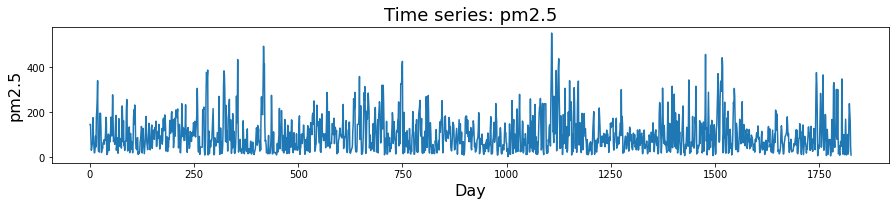

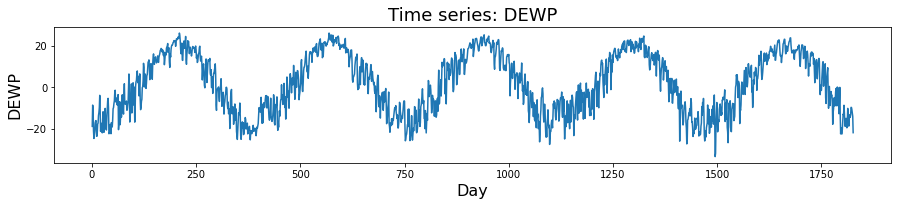

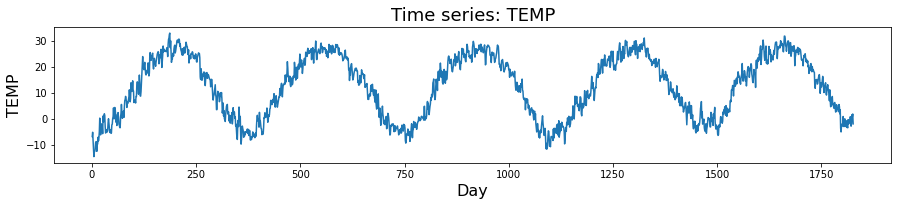

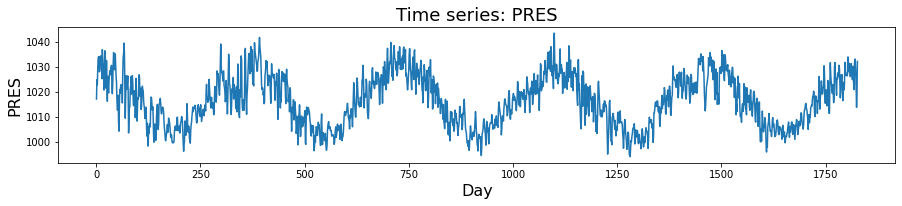

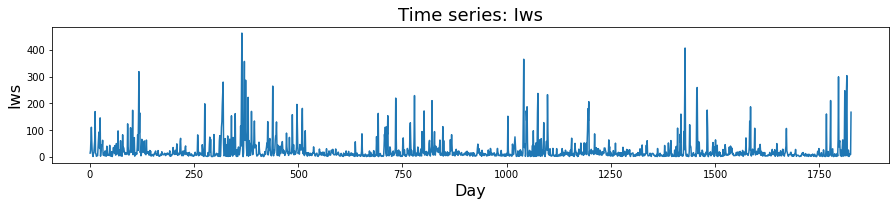

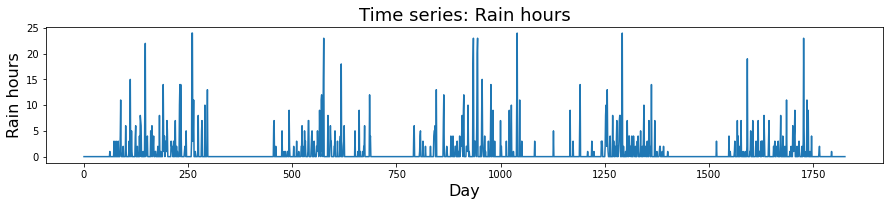

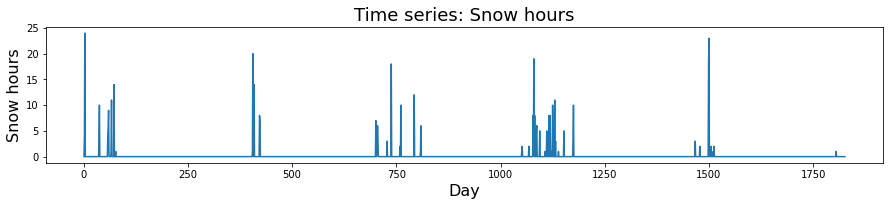

In [9]:
#what does our data look like?
indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']
for i in indices:
  fig = plt.figure(figsize =(15, 2.5)) 
  plt.title("Time series: " + i, size=18) 
  plt.xlabel('Day', size=16)
  plt.ylabel(i, size=16)
  plt.plot(df['day (cumulative)'],df[i])
  plt.show()

dataset normalization

In [10]:
from sklearn import preprocessing

np_values_array = df[['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']].values
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled_values = min_max_scaler.fit_transform(np_values_array)
df_normal = pd.DataFrame(df_scaled_values, columns = indices)
df_normal_day = df_normal.copy()
df_normal_day['day'] = df['day (cumulative)']

In [11]:
df.head()

day (cumulative)       pm2.5       DEWP  ...         Iws  Rain hours  Snow hours
0                 1  145.958333 -18.750000  ...   14.458333           0           0
1                 2  145.958333  -8.500000  ...   24.860000           0           4
2                 3   78.833333 -10.125000  ...   70.937917           0          24
3                 4   31.333333 -20.875000  ...  111.160833           0           0
4                 5   42.458333 -24.583333  ...   56.920000           0           0

[5 rows x 8 columns]

In [12]:
df_normal.head()

pm2.5      DEWP      TEMP      PRES       Iws  Rain hours  Snow hours
0  0.260227  0.244927  0.162852  0.466273  0.028251         0.0    0.000000
1  0.260227  0.417075  0.197183  0.621417  0.050777         0.0    0.166667
2  0.138075  0.389783  0.125000  0.581788  0.150561         0.0    1.000000
3  0.051636  0.209237  0.062500  0.713322  0.237666         0.0    0.000000
4  0.071881  0.146956  0.000000  0.801012  0.120205         0.0    0.000000

sanity check for normal values

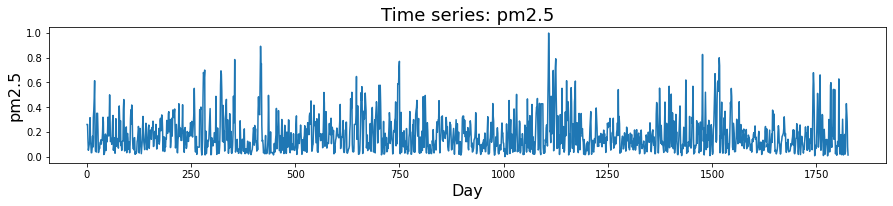

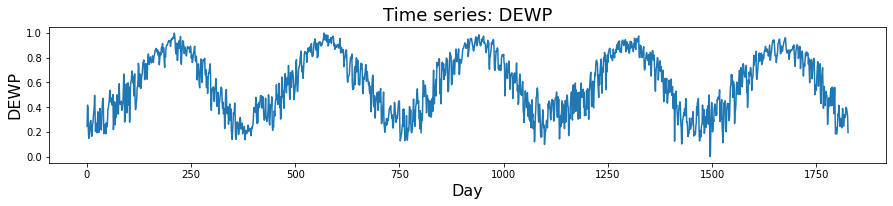

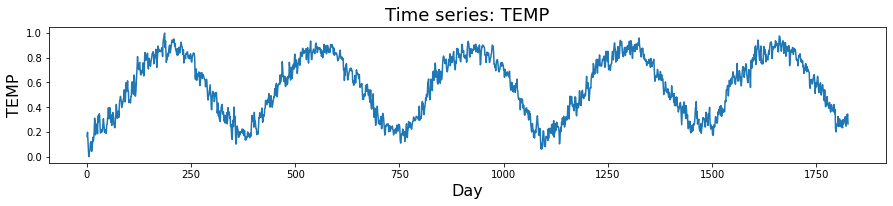

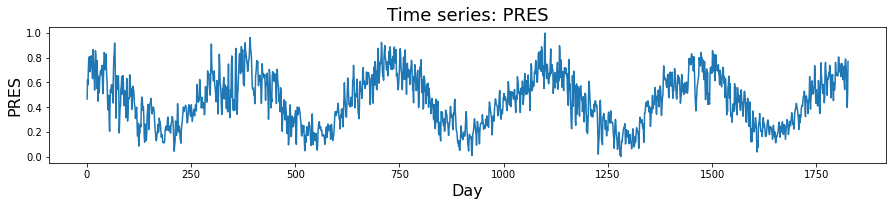

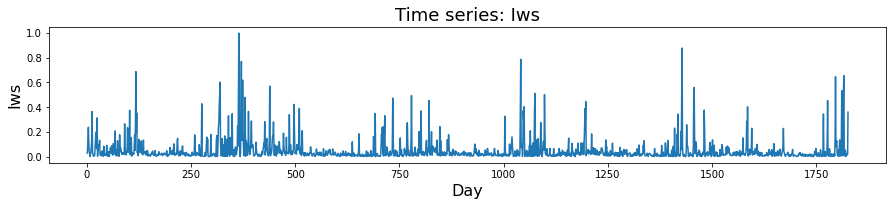

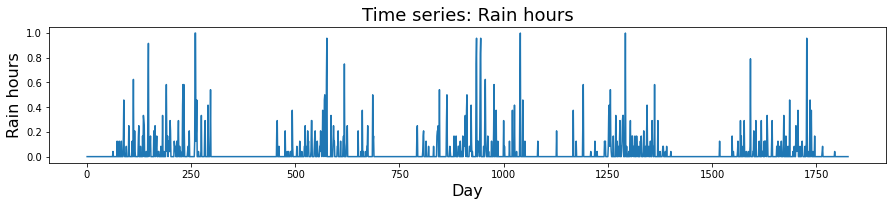

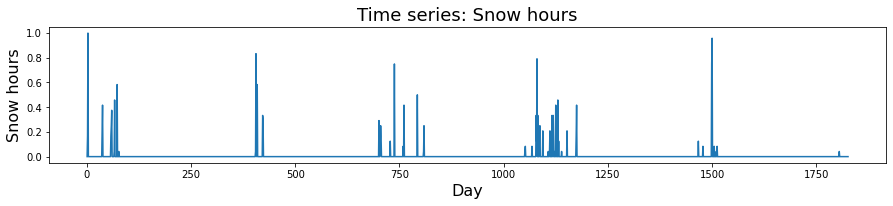

In [13]:
indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']
for i in indices:
  fig = plt.figure(figsize =(15, 2.5)) 
  plt.title("Time series: " + i, size=18) 
  plt.xlabel('Day', size=16)
  plt.ylabel(i, size=16)
  plt.plot(df_normal_day['day'],df_normal_day[i])
  plt.show()


VAR goes here

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
#m = VAR(df_normal.iloc[0:731])
#r = m.fit(1)
#var_model is the model, df_arg is the dataframe, percentage_train is how much of the DF was used to train
#this just grabs the MSE of a VAR model with predicted values against the next interval
def var_predictions_mse(var_model, df_arg, percentage_train, lag_order):
  predictions = var_model.forecast(df_arg.iloc[lag_order+int(np.ceil((percentage_train-0.2)*len(df_arg))):int(np.ceil((percentage_train)*len(df_arg)))].values, 365)
  temp_values = df_arg.iloc[lag_order+int(np.ceil(percentage_train*len(df_arg))):int(np.ceil((percentage_train+0.2)*len(df_arg)))].values
  differences = predictions[:len(temp_values)] - temp_values
  mses = []
  for i in differences:
    temp_list = []
    for x in i:
      temp_list.append(x*x)
    mses.append(sum(temp_list)/7)
  return sum(mses)/len(mses)

#print(var_prediction_mse(r, df_normal, 0.4, 2))

In [16]:
#results_list = []
#for i in range(20):
#  results = model.fit(i+1)
#  #results.summary()
#  results_list.append(results)

In [17]:
#set up models...
model_normal_20 = VAR(df_normal.iloc[:365])
model_normal_40 = VAR(df_normal.iloc[:731])
model_normal_60 = VAR(df_normal.iloc[:1096])
model_normal_80 = VAR(df_normal.iloc[:1461])

In [18]:
#fit models
#this is a ton, i am shocked that this didn't crash
#guess VAR is very simple
results_list_normal_20 = []
for i in range(20):
  results = model_normal_20.fit(i+1)
  #results.summary()
  results_list_normal_20.append(results)
results_list_normal_40 = []
for i in range(20):
  results = model_normal_40.fit(i+1)
  #results.summary()
  results_list_normal_40.append(results)
results_list_normal_60 = []
for i in range(20):
  results = model_normal_60.fit(i+1)
  #results.summary()
  results_list_normal_60.append(results)
results_list_normal_80 = []
for i in range(20):
  results = model_normal_80.fit(i+1)
  #results.summary()
  results_list_normal_80.append(results)

In [19]:
#AIC and MSE for VAR models
#temp_list here takes the mean of the model scores (same architecture but trained on training sets of differing sizes - cross validation)
temp_list = []
temp_list_unagg = []
for i in range(1,21):
  print('Lag Order =', i)
  print('20% training')
  print('AIC : ', results_list_normal_20[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i))
  print('40% training')
  print('AIC : ', results_list_normal_40[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i))  
  print('60% training')
  print('AIC : ', results_list_normal_60[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i))  
  print('80% training')
  print('AIC : ', results_list_normal_80[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i))  
  temp_list.append([i, (results_list_normal_20[i-1].aic+results_list_normal_40[i-1].aic+results_list_normal_60[i-1].aic+results_list_normal_80[i-1].aic)/4,
                    (var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i)+var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i)+var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i)+var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i))/4,
                    (np.sqrt(var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i))+np.sqrt(var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i))+np.sqrt(var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i))+np.sqrt(var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i)))/4])
  temp_list_unagg.append([i, 0.2,results_list_normal_20[i-1].aic, var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i), np.sqrt(var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i))])
  temp_list_unagg.append([i, 0.4,results_list_normal_40[i-1].aic, var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i), np.sqrt(var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i))])
  temp_list_unagg.append([i, 0.6,results_list_normal_60[i-1].aic, var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i), np.sqrt(var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i))])
  temp_list_unagg.append([i, 0.8,results_list_normal_80[i-1].aic, var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i), np.sqrt(var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i))])

Lag Order = 1
20% training
AIC :  -36.29911046665786
MSE :  0.02642001958406455
40% training
AIC :  -37.21451859994303
MSE :  0.026713530690545165
60% training
AIC :  -37.13774266351284
MSE :  0.025777660908980992
80% training
AIC :  -37.23659610153114
MSE :  0.02412482346972258
Lag Order = 2
20% training
AIC :  -36.559411958398144
MSE :  0.02590241748800515
40% training
AIC :  -37.414114357327485
MSE :  0.028713497464596862
60% training
AIC :  -37.35182189437906
MSE :  0.027941919116491205
80% training
AIC :  -37.45639819316884
MSE :  0.024969266099771893
Lag Order = 3
20% training
AIC :  -37.214463867473334
MSE :  0.02639648754940265
40% training
AIC :  -37.78644587725062
MSE :  0.029508143696405153
60% training
AIC :  -37.572598557753146
MSE :  0.029425546890806467
80% training
AIC :  -37.63941413377865
MSE :  0.025441220482986606
Lag Order = 4
20% training
AIC :  -37.12479340196693
MSE :  0.02600055015250504
40% training
AIC :  -37.756304411685434
MSE :  0.03046962324166293
60% tra

In [20]:
#format it as a nice little DF and we are done
VAR_results_df = pd.DataFrame(temp_list, columns=['Order','AIC','MSE','RMSE'])
VAR_results_df

Order        AIC       MSE      RMSE
0       1 -36.971992  0.025759  0.160465
1       2 -37.195437  0.026882  0.163892
2       3 -37.553231  0.027693  0.166323
3       4 -37.524740  0.028140  0.167599
4       5 -37.465152  0.027953  0.166991
5       6 -37.416288  0.029011  0.170020
6       7 -37.373152  0.030368  0.173905
7       8 -37.339114  0.029764  0.172216
8       9 -37.311338  0.029388  0.171068
9      10 -37.263677  0.029624  0.171787
10     11 -37.183196  0.029892  0.172581
11     12 -37.148025  0.027694  0.166198
12     13 -37.082589  0.026954  0.163962
13     14 -37.011870  0.026234  0.161720
14     15 -37.001693  0.025000  0.157862
15     16 -36.941791  0.024516  0.156301
16     17 -36.899181  0.023293  0.152431
17     18 -36.851542  0.023674  0.153474
18     19 -36.816915  0.024422  0.155583
19     20 -36.785853  0.022546  0.149501

In [21]:
VAR_results_df_unagg = pd.DataFrame(temp_list_unagg, columns=['Order','Training Percent','AIC','MSE','RMSE'])
VAR_results_df_unagg

Order  Training Percent        AIC       MSE      RMSE
0       1               0.2 -36.299110  0.026420  0.162542
1       1               0.4 -37.214519  0.026714  0.163443
2       1               0.6 -37.137743  0.025778  0.160554
3       1               0.8 -37.236596  0.024125  0.155322
4       2               0.2 -36.559412  0.025902  0.160942
..    ...               ...        ...       ...       ...
75     19               0.8 -37.382221  0.017720  0.133116
76     20               0.2 -35.717437  0.024712  0.157199
77     20               0.4 -36.994265  0.028186  0.167886
78     20               0.6 -37.083954  0.019944  0.141223
79     20               0.8 -37.347756  0.017344  0.131696

[80 rows x 5 columns]

LSTM goes here

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
dfvalues = df_no_day.values.astype('float32')
dfnvalues = df_normal.values.astype('float32')

In [23]:
#refactored code for the LSTM network, architecture can be adjusted

In [24]:
#these are divided by the number of predicted features to give you average error per feature
def calculate_mse_interval(model, testx, testy):
  index = 0
  prediction_vector = model.predict(testx)
  difference_vector = prediction_vector - testy
  mses = []
  for i in difference_vector:
    mses.append(sum(i*i)/7)
  return sum(mses)/len(mses)

def calculate_mae_interval(model, testx, testy):
  index = 0
  prediction_vector = model.predict(testx)
  difference_vector = prediction_vector - testy
  maes = []
  for i in difference_vector:
    maesl = []
    for x in i:
      maesl.append(np.abs(x))
    maes.append(sum(maesl)/7)
  return sum(maes)/len(maes)

#this doesn't work because some observations are 0
#also because the values are normalized
#MAPE is just a bad choice for evaluating this kind of model
#def calculate_mape_interval(model, testx, testy):
#  index = 0
#  prediction_vector = model.predict(testx)
#  mapes = []
#  index = 0
#  for i in testy:
#    mapesl = []
#    index_y = 0
#    for x in i:
#      mapesl.append(np.abs(x-prediction_vector[index][index_y])/x)
#      index_y += 1
#    mapes.append(sum(mapesl))
#    index += 1
#  return sum(mapes)/len(mapes)

In [25]:
def calculate_mse_interval_list(model, testx, testy):
  index = 0
  prediction_vector = model.predict(testx)
  difference_vector = prediction_vector - testy
  mses = []
  for i in difference_vector:
    mses.append(sum(i*i)/7)
  return mses

In [26]:
#assume values are normalized, but could be interested to see results if they are not
#ARGUMENTS:
#df_arg = dataframe with normalized values, only features that are relevant
#time_lags = number of time steps to look back in time
#train_size = percentage of data (from the first normalized dataset, not the time-series shifted one) to use for training
#directions = 1 or 2, either unidirectional or bidirectional LSTM layers
#number_of_layers = do i really need to explain this?
#dropout_percent = dropout value for LSTM layers
#number_of_epochs = also pretty self explanatory
def LSTM_function(df_arg, time_lags, train_size, directions, number_of_layers, dropout_percent, number_of_epochs):
  indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']

  #dfnl stands for dataframe normalized with lags
  dfnl = df_arg.copy()

  #set up time series with lags
  for i in range(1, time_lags):
    for ind in indices:
      dfnl[ind+'_lag_'+str(i)] = df_arg.shift(periods=i)[ind]

  #v for values
  dfnlv = dfnl.values.astype('float32')

  #what an ugly two lines of code! it's supposed to break up the test and train set into train_size percent, and 1-train_size percent for test
  train = dfnlv[time_lags:int(np.ceil(train_size*len(df_arg)))]
  test = dfnlv[int(np.ceil(train_size*len(df_arg))):int(np.ceil((train_size+0.2)*len(df_arg)))]

  #split into predicted and unpredicted values
  trainx, trainy = train[:, :7*(time_lags-1)], train[:, 7*(time_lags-1):]
  testx, testy = test[:, :7*(time_lags-1)], test[:, 7*(time_lags-1):]

  #reshape into the LSTM RNN desired shape
  trainxr = trainx.reshape((trainx.shape[0], 1, trainx.shape[1]))
  testxr = testx.reshape((testx.shape[0], 1, testx.shape[1]))
  
  #choice of model architecture, this should be modular depending on kwargs
  #you can actually add any number of layers if you want
  model = keras.Sequential()
  if (number_of_layers==1):
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))

  else:
    for i in range(number_of_layers-1):
      if (directions==1):
        model.add(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent))
      elif (directions==2):
        model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent)))
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))       
  model.add(layers.Dense(7))

  #compile with MSE and adam optimizer
  model.compile(loss='mse', optimizer='adam')

  history = model.fit(trainxr, trainy, epochs=number_of_epochs, batch_size=50, validation_data=(testxr, testy), verbose=2, shuffle=False)

  #plot the loss values 
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Test loss')
  plt.legend()
  plt.show()

  #model summary
  print(model.summary())
  print("Model parameters: ")
  print("Time lags: ", time_lags)
  print("Training set size: "+str(train_size*100)+"%, or "+str(train_size*1825-time_lags))
  print("Number of epochs: "+str(number_of_epochs))
  print("Number of layers: "+str(number_of_layers))
  print("Dropout percent: "+str(dropout_percent))
  mae_interval = calculate_mae_interval(model, testxr, testy)
  print("MAE (interval): ", mae_interval)
  mse_interval = calculate_mse_interval(model, testxr, testy)
  print("MSE (interval): ", mse_interval)
  rmse_interval = np.sqrt(calculate_mse_interval(model, testxr, testy))
  print("RMSE (interval): ", rmse_interval)  

  #return all parameters that you need for evaluation
  return [time_lags, train_size, directions, number_of_layers, dropout_percent, number_of_epochs, mae_interval, mse_interval, rmse_interval]
#  return model

#m = LSTM_function(df_normal, 10, 0.2, 2, 2, 0, 100)

In [27]:
#assume values are normalized, but could be interested to see results if they are not
#ARGUMENTS:
#df_arg = dataframe with normalized values, only features that are relevant
#time_lags = number of time steps to look back in time
#train_size = percentage of data (from the first normalized dataset, not the time-series shifted one) to use for training
#directions = 1 or 2, either unidirectional or bidirectional LSTM layers
#number_of_layers = do i really need to explain this?
#dropout_percent = dropout value for LSTM layers
#number_of_epochs = also pretty self explanatory
def LSTM_function_mse_list(df_arg, time_lags, train_size, directions, number_of_layers, dropout_percent, number_of_epochs):
  indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']

  #dfnl stands for dataframe normalized with lags
  dfnl = df_arg.copy()

  #set up time series with lags
  for i in range(1, time_lags):
    for ind in indices:
      dfnl[ind+'_lag_'+str(i)] = df_arg.shift(periods=i)[ind]

  #v for values
  dfnlv = dfnl.values.astype('float32')

  #what an ugly two lines of code! it's supposed to break up the test and train set into train_size percent, and 1-train_size percent for test
  train = dfnlv[time_lags:int(np.ceil(train_size*len(df_arg)))]
  test = dfnlv[int(np.ceil(train_size*len(df_arg))):int(np.ceil((train_size+0.2)*len(df_arg)))]

  #split into predicted and unpredicted values
  trainx, trainy = train[:, :7*(time_lags-1)], train[:, 7*(time_lags-1):]
  testx, testy = test[:, :7*(time_lags-1)], test[:, 7*(time_lags-1):]

  #reshape into the LSTM RNN desired shape
  trainxr = trainx.reshape((trainx.shape[0], 1, trainx.shape[1]))
  testxr = testx.reshape((testx.shape[0], 1, testx.shape[1]))
  
  #choice of model architecture, this should be modular depending on kwargs
  #you can actually add any number of layers if you want
  model = keras.Sequential()
  if (number_of_layers==1):
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))

  else:
    for i in range(number_of_layers-1):
      if (directions==1):
        model.add(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent))
      elif (directions==2):
        model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent)))
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))       
  model.add(layers.Dense(7))

  #compile with MSE and adam optimizer
  model.compile(loss='mse', optimizer='adam')

  history = model.fit(trainxr, trainy, epochs=number_of_epochs, batch_size=50, validation_data=(testxr, testy), verbose=2, shuffle=False)

  #plot the loss values 
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Test loss')
  plt.legend()
  plt.show()

  #model summary
  print(model.summary())
  print("Model parameters: ")
  print("Time lags: ", time_lags)
  print("Training set size: "+str(train_size*100)+"%, or "+str(train_size*1825-time_lags))
  print("Number of epochs: "+str(number_of_epochs))
  print("Number of layers: "+str(number_of_layers))
  print("Dropout percent: "+str(dropout_percent))
  mse_interval = calculate_mse_interval_list(model, testxr, testy)
  print("MSE (interval): ", mse_interval)
  rmse_interval = np.sqrt(calculate_mse_interval_list(model, testxr, testy))
  print("RMSE (interval): ", rmse_interval)  

  #return all parameters that you need for evaluation
  return [time_lags, train_size, directions, number_of_layers, dropout_percent, mse_interval, rmse_interval]
#  return model

#m = LSTM_function(df_normal, 10, 0.2, 2, 2, 0, 100)

In [28]:
#reposted from above
#ARGUMENTS:
#df_arg = dataframe with normalized values, only features that are relevant
#time_lags = number of time steps to look back in time
#train_size = percentage of data (from the first normalized dataset, not the time-series shifted one) to use for training
#directions = 1 or 2, either unidirectional or bidirectional LSTM layers
#number_of_layers = do i really need to explain this?
#dropout_percent = dropout value for LSTM layers
#number_of_epochs = also pretty self explanatory
timelags = [10,20]
num_layers = [1,2]
directions = [1,2]
dropouts = [0,0.2,0.4]
cross_validation_intervals = [0.2,0.4,0.6,0.8]
#m = LSTM_function(df_normal, 10, 0.2, 2, 2, 0, 100)

Epoch 1/100
8/8 - 0s - loss: 0.1550 - val_loss: 0.1543
Epoch 2/100
8/8 - 0s - loss: 0.1481 - val_loss: 0.1475
Epoch 3/100
8/8 - 0s - loss: 0.1414 - val_loss: 0.1411
Epoch 4/100
8/8 - 0s - loss: 0.1351 - val_loss: 0.1348
Epoch 5/100
8/8 - 0s - loss: 0.1290 - val_loss: 0.1289
Epoch 6/100
8/8 - 0s - loss: 0.1231 - val_loss: 0.1232
Epoch 7/100
8/8 - 0s - loss: 0.1175 - val_loss: 0.1177
Epoch 8/100
8/8 - 0s - loss: 0.1122 - val_loss: 0.1125
Epoch 9/100
8/8 - 0s - loss: 0.1070 - val_loss: 0.1074
Epoch 10/100
8/8 - 0s - loss: 0.1021 - val_loss: 0.1026
Epoch 11/100
8/8 - 0s - loss: 0.0974 - val_loss: 0.0980
Epoch 12/100
8/8 - 0s - loss: 0.0930 - val_loss: 0.0937
Epoch 13/100
8/8 - 0s - loss: 0.0887 - val_loss: 0.0895
Epoch 14/100
8/8 - 0s - loss: 0.0847 - val_loss: 0.0856
Epoch 15/100
8/8 - 0s - loss: 0.0809 - val_loss: 0.0818
Epoch 16/100
8/8 - 0s - loss: 0.0773 - val_loss: 0.0783
Epoch 17/100
8/8 - 0s - loss: 0.0738 - val_loss: 0.0750
Epoch 18/100
8/8 - 0s - loss: 0.0706 - val_loss: 0.0718
E

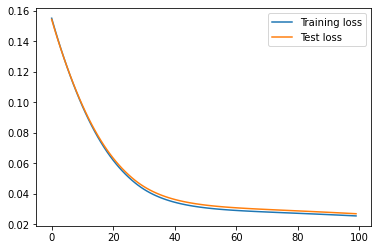

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                32768     
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.054374827822487405, 0.06912835839778252, 0.0403303421252141, 0.01880847769955705, 0.015415967985323473, 0.027516529494148147, 0.02115774939427086, 0.06640154832816084, 0.16780048980685283, 0.05724034509330522, 0.0444151729233064, 0.032157883704972585, 0.024439203153763498, 0.055690652408104925, 0.12680301499286933, 0.03607912338130908, 0.026311094583694024,

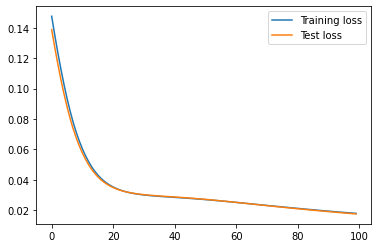

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.011007888968297916, 0.012847730501537822, 0.01820800924137497, 0.0269630746735012, 0.020413922276312797, 0.017088334531097513, 0.03028764087412128, 0.01979331914325095, 0.013700482949778754, 0.01881567715125649, 0.010783934252685867, 0.045821515571463224, 0.028860426703269177, 0.01866976978366048, 0.029101370283659174, 0.10391627082844934, 0.0210360887372

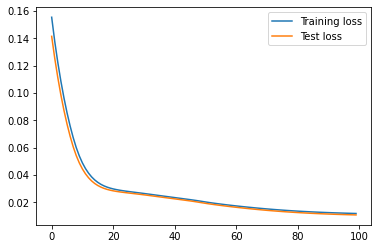

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.01576818802485442, 0.030967074895053365, 0.020364317353336707, 0.032149635231495007, 0.027727426117443037, 0.01750061410608136, 0.01695555464734103, 0.006900455449665189, 0.006755538507215013, 0.0054261702271105605, 0.060418886329508883, 0.0420044324972488, 0.01687817484577993, 0.01015240047568763, 0.006233352278806186, 0.005543138374118176, 0.0083197102

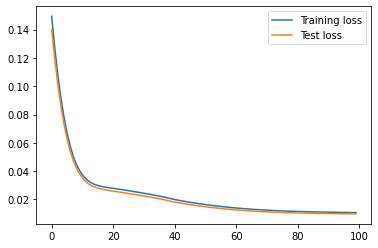

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.005412936479842756, 0.02918400601785314, 0.004754585041415079, 0.04624627539305948, 0.04664770929541971, 0.01332578202085902, 0.009257768544817477, 0.012058029574940779, 0.012792188174249272, 0.010888708882183502, 0.004470562388762899, 0.0025262182493211833, 0.0030307323977467604, 0.00045374561068456387, 0.005291247926314619, 0.0011186187262605277, 0.012

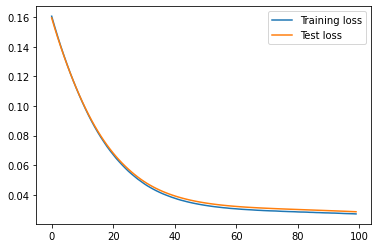

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.05799957887419233, 0.07289608913041386, 0.04426958360792404, 0.02228016494570641, 0.01906204382872342, 0.032618204377026165, 0.02511043440400889, 0.07311893236640442, 0.17633453539955163, 0.06184455642193955, 0.046909051934822595, 0.03460433511229764, 0.027354108086521074, 0.06044741376535967, 0.1324857449466695, 0.039563085684286695, 0.0296279635305316

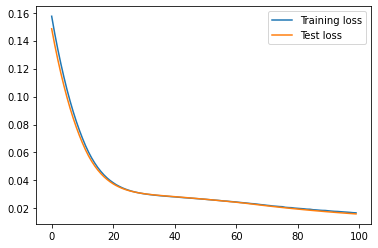

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.008558794102731733, 0.010198140851059634, 0.01486517189407875, 0.02305031843843608, 0.017699702408922997, 0.014411889017018049, 0.02590760261903467, 0.01651562740283095, 0.011114299096724218, 0.015166038629623861, 0.007974065842323139, 0.04164478697774549, 0.024473098628212547, 0.015248999573356872, 0.02487525066843383, 0.100100991713394, 0.018183774620

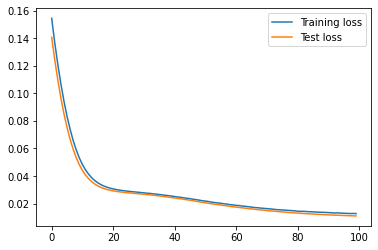

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.016461927470962628, 0.031932955407488146, 0.021149985539653113, 0.033107590878639064, 0.028838853233732413, 0.018325151802530724, 0.01747069511981993, 0.007380533912964893, 0.007078586905143831, 0.005777690216811087, 0.06161149856805943, 0.04346379492692774, 0.01799226898921396, 0.010849980284287344, 0.006745598532039107, 0.006018646972734132, 0.009031

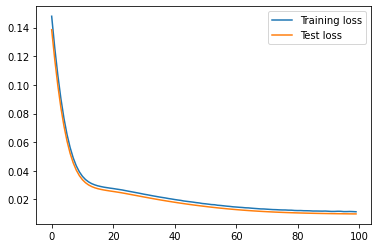

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.00555149058241763, 0.02901929684074795, 0.004768428691022564, 0.046992388362663666, 0.04738595884867079, 0.013835503669854785, 0.009710964971288507, 0.012507463975842776, 0.013076986907565567, 0.011050317588212368, 0.004403185437695356, 0.0026009678035084755, 0.002894660615441223, 0.0004319040546241532, 0.004979654389688092, 0.0011022847247659229, 0.01

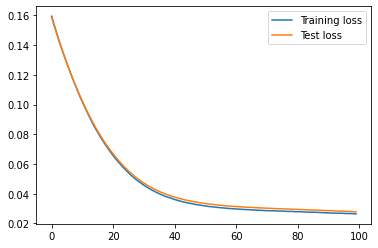

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.057498586237280894, 0.0723543108033482, 0.04310930134358516, 0.020933480409439653, 0.01741207547976436, 0.030637528869972033, 0.02360004240264451, 0.07110527388743192, 0.17430690834381884, 0.06122318857316194, 0.04658896372503867, 0.034348680789532536, 0.02662731415018373, 0.059256422131771354, 0.1315560458710284, 0.03881116999920258, 0.0288951234085418

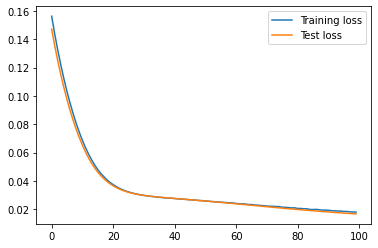

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.01033174900827102, 0.012033526446690044, 0.01686542165985624, 0.025143548289861428, 0.019280350815311716, 0.015693425805904684, 0.02795855728170084, 0.018061400250222244, 0.012732395007170843, 0.01716912768675424, 0.00961329318085648, 0.043715007727084094, 0.027056930924162868, 0.017848500336120714, 0.02719008247608404, 0.10240403618445271, 0.0198532436

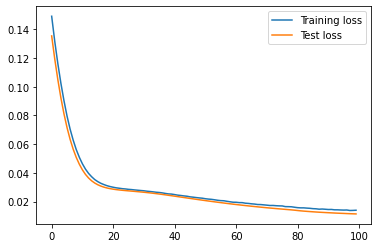

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                32768     
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.01754947371279871, 0.03278603335430879, 0.021335551437524764, 0.03429427284936537, 0.029918932755338443, 0.018798602511586587, 0.017891980499501057, 0.008000214293393324, 0.007213121403765399, 0.0053985901434186545, 0.0629530881908847, 0.04549358084789544, 0.019220113677355193, 0.011700106268628068, 0.0074097554154702394, 0.006373537585334686, 0.00989

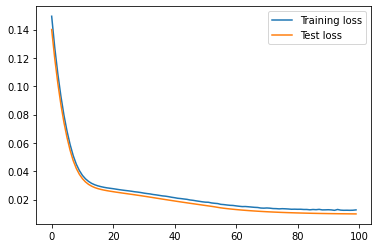

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                32768     
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 455       
Total params: 33,223
Trainable params: 33,223
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.005404124226645633, 0.0294919072844745, 0.004994722116472465, 0.04688948544935556, 0.04790760093393536, 0.014145391346703815, 0.009835798536576996, 0.012419098977781167, 0.012954034503699014, 0.010855083046148397, 0.004465410718434474, 0.00241197495675546, 0.003042208601462854, 0.00043943418079704443, 0.00510995335363467, 0.0009718826518759929, 0.0126

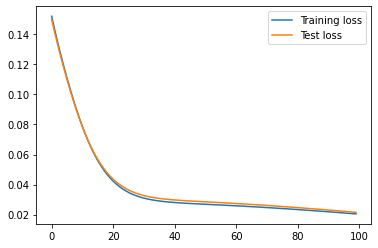

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               65536     
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.042967047465156484, 0.05589325659145418, 0.02899305183642095, 0.01055868909887587, 0.007687758205910151, 0.017595638716946787, 0.011322697181835142, 0.05359396905052043, 0.15616119999090675, 0.0456624250909794, 0.03406906338612105, 0.023066323657141247, 0.015442982521433026, 0.04506935638885677, 0.11692740326316198, 0.026584153510546975, 0.01748585414916

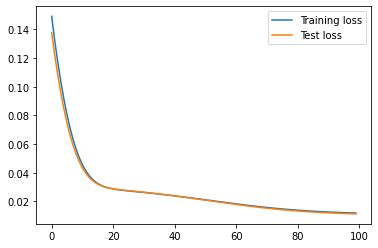

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.0024963993097506837, 0.0037397807211293965, 0.0058869966528293715, 0.011958757661091113, 0.010132886575044202, 0.007704690844125902, 0.01529625375236979, 0.009071775640580069, 0.0048997624884025625, 0.005917876929028613, 0.002097200269775255, 0.03064622769089961, 0.012404861440653494, 0.005369679756443345, 0.012442985122366476, 0.09023506173772537, 0.010

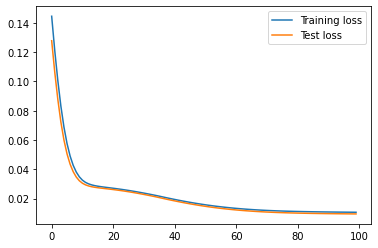

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.009243365533036143, 0.021529540172066066, 0.014448482601437718, 0.022693350733139335, 0.01997690091970331, 0.013163742322701313, 0.015750079882829077, 0.0032450532105160945, 0.003970327457880428, 0.003353100092551488, 0.049247960010688985, 0.03126491442890256, 0.010137884216289552, 0.005594403362920275, 0.002796151145698137, 0.0031333527492409174, 0.003

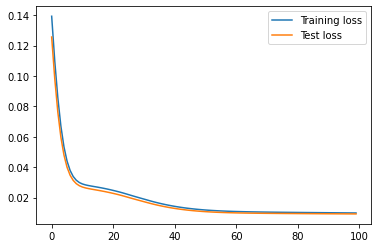

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.003555161629654841, 0.028639447408620202, 0.004976817081631018, 0.042417869404224415, 0.04457038746997049, 0.012390552868185165, 0.0090502256810266, 0.012658484357026671, 0.014832461164457657, 0.013645642529549409, 0.0060279691866266406, 0.003885653594937009, 0.003863174026229948, 0.0011052375766666955, 0.006227573479074116, 0.0017590266303467875, 0.008

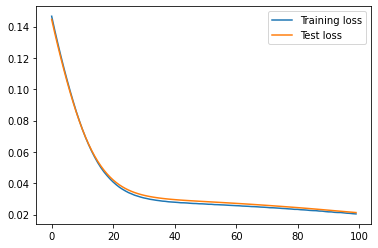

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.0427025053338314, 0.05539367822192227, 0.028987463905650657, 0.010993437083210924, 0.008235496422717656, 0.017933996033219404, 0.011715584972955233, 0.05363003686014573, 0.15566893833270765, 0.04530410796639574, 0.03373400819964445, 0.022756199660631995, 0.015520159739025985, 0.044826554188668, 0.11609178441358381, 0.026291718355813436, 0.0173855844724

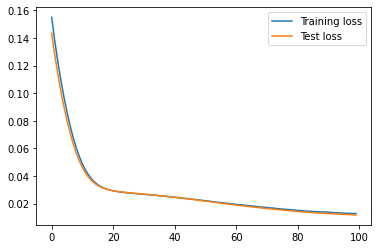

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.003425353946373174, 0.004820634661785205, 0.0074838407111355665, 0.014047667315500303, 0.011289304503009134, 0.008738974681022122, 0.017359664213602497, 0.0103270328857304, 0.005751951623194275, 0.007535774857907589, 0.0028918867183165275, 0.032590254032730366, 0.014727292249647559, 0.006983478536052904, 0.014789078259484865, 0.09202838709656394, 0.011

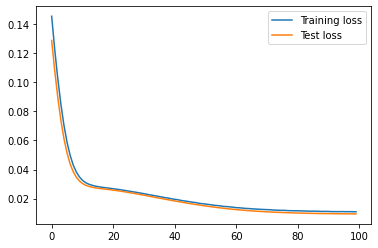

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_18 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.009140517847200158, 0.02141925516163821, 0.014747515118135166, 0.022763522043508795, 0.020202474921104243, 0.01342557405307941, 0.015886884227906455, 0.003169420415523356, 0.00390089437460769, 0.0034280029646457217, 0.049195570248554886, 0.031240723015668794, 0.010325486329618019, 0.005714213623702692, 0.002866102220455754, 0.003276834171953981, 0.003

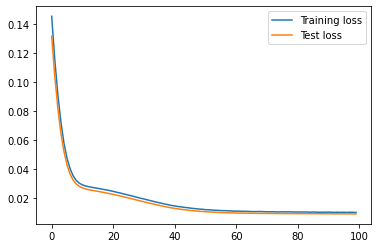

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.003429926397075178, 0.028356604382029867, 0.004636016845519667, 0.0422514009322705, 0.04473089576016979, 0.012526134633974704, 0.009209285213728435, 0.01292055101657752, 0.014991895529549635, 0.01358015200509856, 0.006224411328730639, 0.0039023010924990687, 0.004023116671175687, 0.0011489607149997028, 0.006340420578063848, 0.0017513848757906608, 0.008

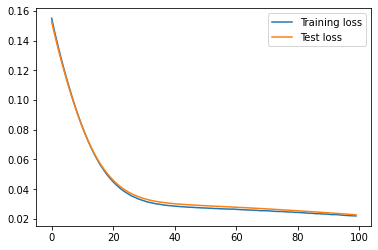

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.04723263516124072, 0.060538024870246385, 0.032891671709616536, 0.01320247132181456, 0.00988849850598074, 0.021027457586439726, 0.01465437764584619, 0.058096619946549515, 0.16088581271469593, 0.05003588346465092, 0.03762549483716222, 0.02593189649633132, 0.018456919742415527, 0.04889081064902712, 0.12082435027696192, 0.029899990165306787, 0.020364322974

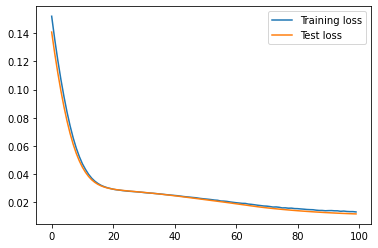

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 128)               65536     
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.003171305925572402, 0.0044699178433437025, 0.006855020077913261, 0.013146619385630791, 0.010726440448706853, 0.008147424593159616, 0.016294036468804864, 0.009501013615850493, 0.0051711968551119624, 0.006764478365117351, 0.002496876988906089, 0.031840973299170273, 0.013786064659273376, 0.006439942152610456, 0.01384039859215136, 0.09116468073852957, 0.01

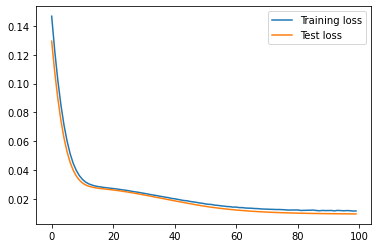

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 128)               65536     
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.00872513429791739, 0.020766963617721297, 0.014423555060652501, 0.022042285692579964, 0.019668553854476807, 0.013170808238442078, 0.015825890045009925, 0.00298343159391834, 0.003841429761434613, 0.0035002185050601042, 0.048654024359556, 0.03076754945141147, 0.010186855987090635, 0.005683105675676156, 0.0027570952580780223, 0.0032223050915750457, 0.0034

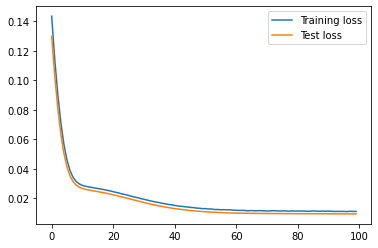

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 128)               65536     
_________________________________________________________________
dense_23 (Dense)             (None, 7)                 903       
Total params: 66,439
Trainable params: 66,439
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.0033891395760292653, 0.027625180649400654, 0.004238289390741556, 0.04304683592324311, 0.04555234068746878, 0.012899993288946072, 0.009562192068967437, 0.013128487964942386, 0.014966908213474588, 0.013436356321368035, 0.006110053989687003, 0.003774462646106258, 0.0039538171336711714, 0.0010875782567641831, 0.006078666741554376, 0.0015409375557737803, 0

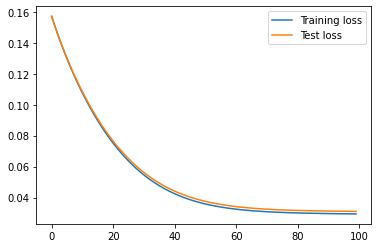

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.06447558001049661, 0.07983437307848362, 0.050208787579322234, 0.027021134706712604, 0.023800988839606622, 0.03771814921180651, 0.030137782721015225, 0.07915481368295982, 0.1819314052325873, 0.06735323611584525, 0.05175084668

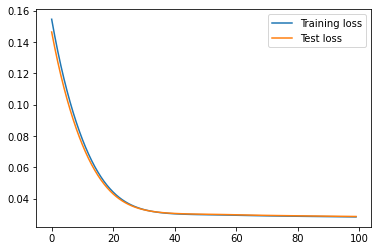

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_25 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.02849333973115011, 0.03064040233065108, 0.03735700762938775, 0.04693202784671614, 0.037319137316704394, 0.03252292184853494, 0.05085293499619833, 0.036510082920098545, 0.03138547696705375, 0.03948184019308038, 0.029320407387

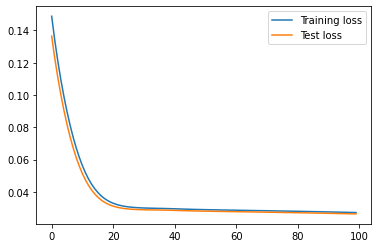

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.060107802827717806, 0.0889390106375296, 0.06719744078041653, 0.08933185749369191, 0.07850479014450684, 0.0576910909543845, 0.04672112248954363, 0.04244096101319883, 0.04058568641526757, 0.03790099312215846, 0.12549282808530

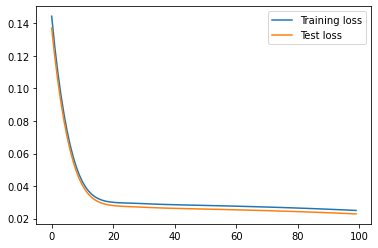

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_27 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.037231401195250716, 0.06295188103935548, 0.03157616749688584, 0.08672024590071357, 0.08054251474511277, 0.04083961554819585, 0.02762777529590364, 0.023642334130792215, 0.016944431034582003, 0.0129396943271526, 0.01206221057

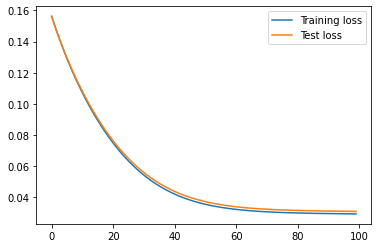

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_33 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.06449512528342893, 0.07988079907538902, 0.050196363319368435, 0.026962378526994662, 0.023688852640459248, 0.03758905244779141, 0.03003917735726905, 0.07904597652460714, 0.18186605870557418, 0.06739373149113297, 0.051814417

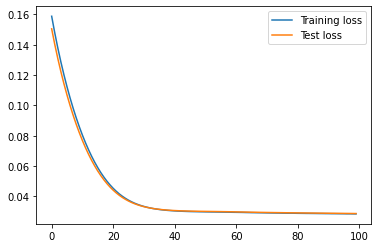

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_29 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.028608579135574734, 0.030782896583592186, 0.03740273927022437, 0.04688330902925892, 0.03719502335401818, 0.03243601174991844, 0.05090349869923167, 0.03644434241245368, 0.03132828416294485, 0.039553816100773735, 0.029414516

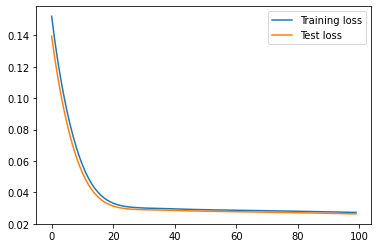

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_37 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_30 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.05978600659987673, 0.08845557380118407, 0.06696027728321496, 0.08881871945465848, 0.07812717498122115, 0.05745737634840355, 0.04651817856730694, 0.04216565428941976, 0.04043179856255717, 0.03790178327033443, 0.12474359655

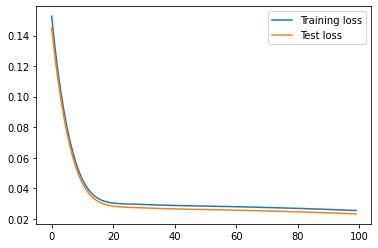

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_31 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.03758625272894278, 0.06344043592356943, 0.032054988359699825, 0.08712205584327291, 0.08099686553136312, 0.04130948195233941, 0.028254615080576122, 0.024285147079873632, 0.01757326310533764, 0.013449834397761151, 0.0125017

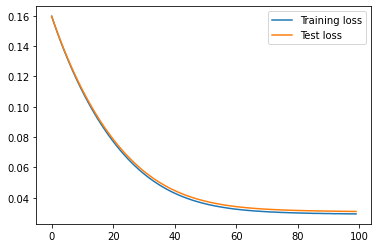

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_41 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_32 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.06455378127741694, 0.07995345245892947, 0.05026345305980483, 0.026990435867966362, 0.02373737039306434, 0.037709645207671984, 0.030131825468353263, 0.0791781241548181, 0.18201252582782348, 0.06745065510040149, 0.0518478090

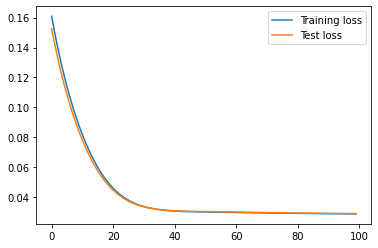

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_33 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.028541151151460196, 0.03069122900758105, 0.03729771942952149, 0.046774197081893884, 0.03716125901285393, 0.03237435740136009, 0.05068535813812299, 0.036354747645548614, 0.03128666256504532, 0.03942370559421501, 0.029304896

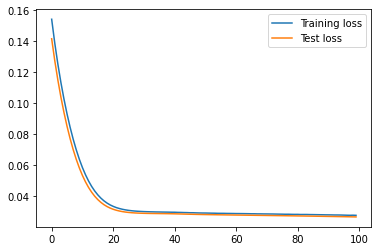

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_45 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.060560942191971535, 0.08943711949021756, 0.06757929913458481, 0.0895746844876807, 0.07877241165884438, 0.05798909068731258, 0.04693614455754869, 0.042843044238647314, 0.04112806938480519, 0.038534429174278885, 0.125864901

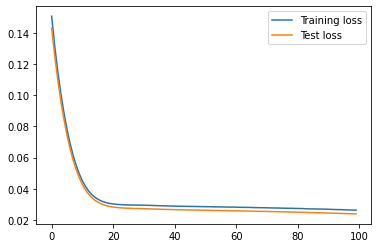

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 1, 64)             32768     
_________________________________________________________________
lstm_47 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_35 (Dense)             (None, 7)                 455       
Total params: 66,247
Trainable params: 66,247
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.038764597656804005, 0.06446540365660829, 0.0330809537055237, 0.08869425998169131, 0.0824327087778199, 0.042617628658522984, 0.02925942781647401, 0.02509842283741039, 0.018185396558172733, 0.013981938929646276, 0.013087931

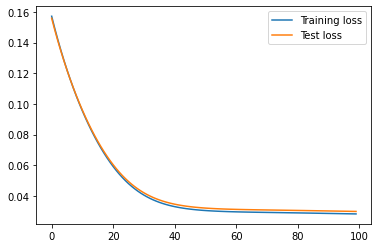

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_36 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.0645298573009703, 0.08009144687405621, 0.049694989372385735, 0.02558244660836603, 0.021713154850918466, 0.0358095284391311, 0.028431424108150947, 0.07775221859213031, 0.1814179065643527, 0.06733186363167729, 0.051901705200

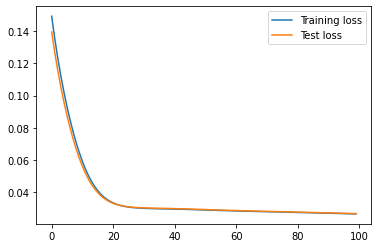

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_37 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.026193827099632472, 0.028417389775443423, 0.035718703018834015, 0.04593106712439164, 0.036220231209881604, 0.03169772462985877, 0.049884108531322066, 0.035642321433572634, 0.029772538267674724, 0.037780977164012644, 0.0273

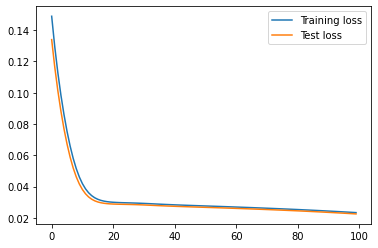

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_16 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_38 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.05334410501319705, 0.07925235387769394, 0.05875068069768271, 0.08120888580119104, 0.07131338882027194, 0.050721482589973936, 0.0408169180619942, 0.03598582824426038, 0.0331198346601533, 0.02988518870032359, 0.114782514807

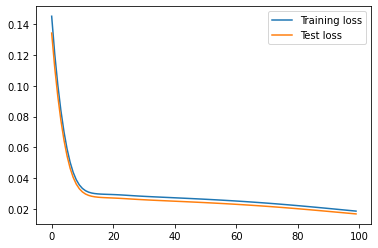

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_39 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.02586886563221924, 0.05103392799771557, 0.020642643535601173, 0.07182704686212153, 0.06684801096811757, 0.029233803723140488, 0.017898651577914797, 0.01523512855588446, 0.01017942333211457, 0.00738786474331781, 0.00575828

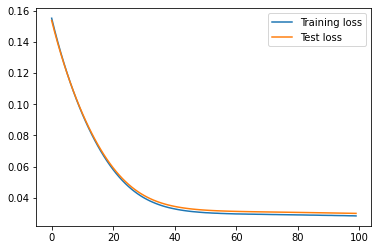

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_40 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.06465258233843738, 0.08015480613019983, 0.04975562919259703, 0.025714466395064455, 0.021875729035985256, 0.03601414784913816, 0.02860640795967941, 0.07787620839891522, 0.18151859788382094, 0.06743453161055056, 0.05197907

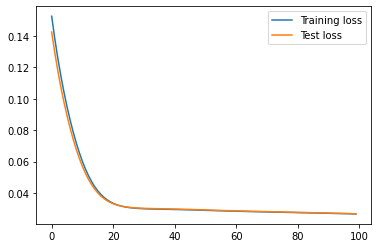

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_41 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.026341806978702413, 0.02855761400548675, 0.03585300216010572, 0.04606816568411887, 0.03633619840236081, 0.03179841449621433, 0.050117304510162546, 0.03577972050490124, 0.02989785778065977, 0.03791527746216161, 0.02748726

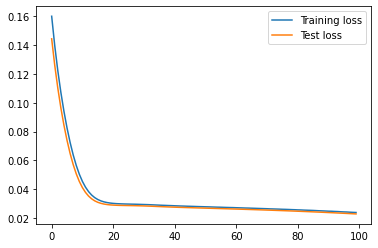

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_24 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_42 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.05386534845976192, 0.08020564169938942, 0.05952165753530737, 0.08190305485082458, 0.07191019148532567, 0.05134666768883887, 0.04151692464594297, 0.03654816944202009, 0.03381026045618845, 0.03062493217605931, 0.115971850

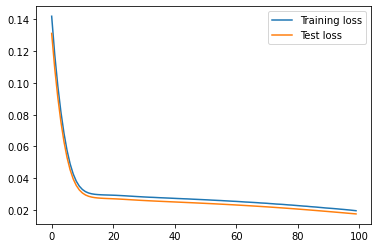

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_26 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_43 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.027719185396563262, 0.053215568739688024, 0.02228406791359053, 0.0738843570039275, 0.0686882924305142, 0.030678928800625727, 0.018833641050150618, 0.01579714935983897, 0.010436471543341343, 0.007598499060674969, 0.00648

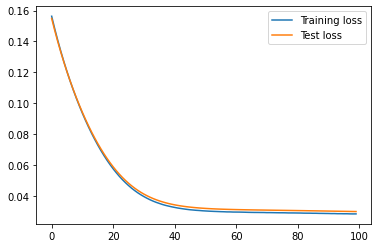

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_28 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_44 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 20.0%, or 355.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.06465212487403603, 0.0801586416585321, 0.04983195406800535, 0.025831155015891585, 0.02198708938210205, 0.03600445472797479, 0.02866129795854379, 0.07771982531786696, 0.18108588822152732, 0.06727461628595068, 0.0519229188

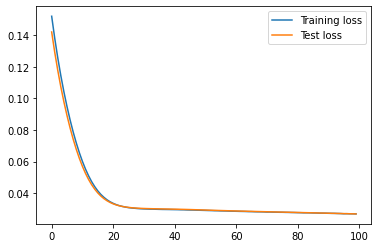

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_30 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_45 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 40.0%, or 720.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.02625364412129524, 0.02845279059381158, 0.035641929885189584, 0.04576816290708458, 0.036092213623175794, 0.03154784564269773, 0.04973715151780717, 0.03549109851675374, 0.02969599309394003, 0.037686390301262564, 0.0273067

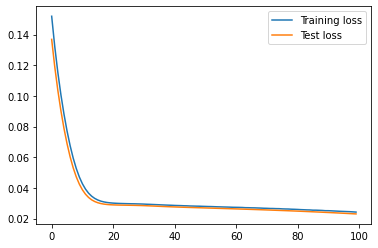

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_32 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_46 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 60.0%, or 1085.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.05390845345807195, 0.08040798567318623, 0.05925818364734629, 0.081759349884773, 0.07167759780090169, 0.05110711670048269, 0.041352060200422, 0.03662676957070029, 0.03387762623190481, 0.03054091720079149, 0.1164465790290

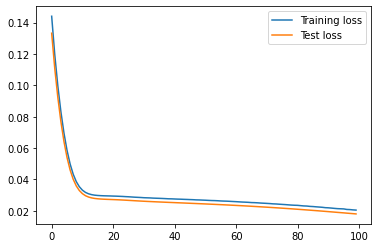

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_34 (Bidirectio (None, 1, 128)            65536     
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_47 (Dense)             (None, 7)                 903       
Total params: 165,255
Trainable params: 165,255
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  10
Training set size: 80.0%, or 1450.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.028556336478296935, 0.05406133182363452, 0.023116003397652612, 0.07535975828899869, 0.07012674540497496, 0.03177914523569468, 0.019668531683107306, 0.01654064361147383, 0.010978410997527785, 0.008043415734261674, 0.0068

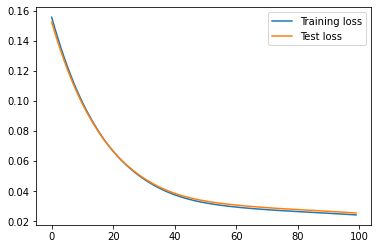

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_48 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.04011931770115292, 0.05684928802241172, 0.06960777192476339, 0.024802400707682994, 0.01591119183077743, 0.028318058973776976, 0.007785359247853714, 0.01272991329200782, 0.061270584801345, 0.010277588225948518, 0.05441396830844626, 0.06922584051166528, 0.04168393175184194, 0.020792428836492554, 0.01860296336605773, 0.029427013218602433, 0.0225566441783615

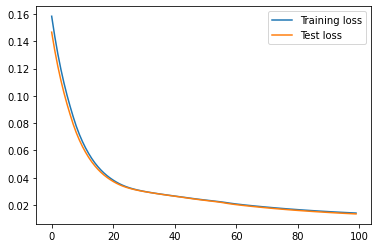

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_49 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.0055358407053063274, 0.01881585270231361, 0.024534943750820406, 0.03901562609046648, 0.015622459881732149, 0.014055797539705444, 0.01126980836241793, 0.006242268968240491, 0.010440962073257001, 0.012618499138105628, 0.005076366606512498, 0.006783807958267322, 0.010187852599951188, 0.017113304762590684, 0.012726569052184849, 0.010008745300741775, 0.021178

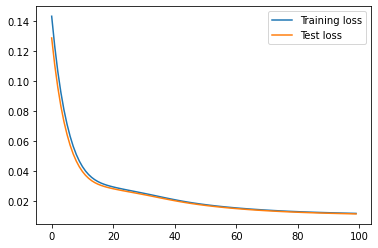

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_50 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.02375230460997305, 0.012656872136306316, 0.09652974384308825, 0.020229195399484264, 0.02263600599495216, 0.010701384730054997, 0.0139899113377656, 0.009445497796280376, 0.02049217316276294, 0.011180389291049713, 0.015764032000983468, 0.03138090733825395, 0.021201511030085385, 0.033362850415869616, 0.028418117427333658, 0.017947191583516542, 0.0175756583

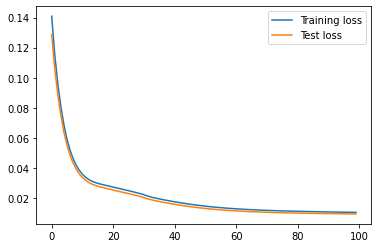

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_51 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.003864274254218409, 0.005260206293184767, 0.008697520926684124, 0.0063737261760772, 0.005346202532174564, 0.007835148814202901, 0.006804467288280388, 0.009473010375066744, 0.008475252473934753, 0.007464267444447614, 0.004995240056554654, 0.028215369996490023, 0.004222387276448509, 0.043418966805932414, 0.043080829893629664, 0.010668027399723152, 0.00847

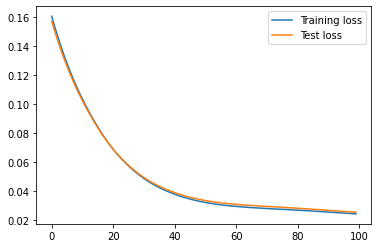

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_52 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.03816001635277644, 0.054912211115671586, 0.06717664487327316, 0.02236998369750966, 0.013920912934866334, 0.026775030203030577, 0.006380325764959187, 0.01144826864973376, 0.060491136325124116, 0.008712044654073128, 0.052097585484651585, 0.06700498170851331, 0.039025873012308566, 0.017906477988926132, 0.01554860450934419, 0.02584973444962608, 0.019785482

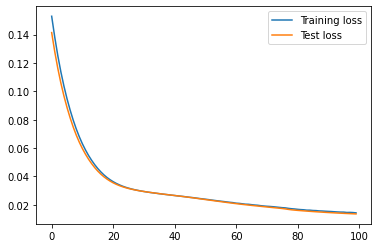

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_53 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.0061620919635093484, 0.019405213841407334, 0.025235325706367866, 0.03980564974598825, 0.01629791540342142, 0.014636667047950271, 0.011579622747264904, 0.006572323280186611, 0.010683606769745144, 0.013014574620476995, 0.005224754683049631, 0.0069645071226237375, 0.01081632725902588, 0.018186940352259335, 0.013541794284913675, 0.010856355994746991, 0.022

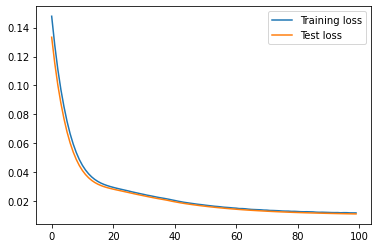

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_54 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.023454479413235925, 0.012591418459903383, 0.09643353923144916, 0.02061922725520812, 0.02272436118229442, 0.010459804639838564, 0.013441096793810305, 0.009114473388763145, 0.020283553363697138, 0.010996646042518219, 0.015213579781889816, 0.030601336299566486, 0.02055987984100024, 0.032458169977222236, 0.027603241451808053, 0.017392565425585156, 0.01723

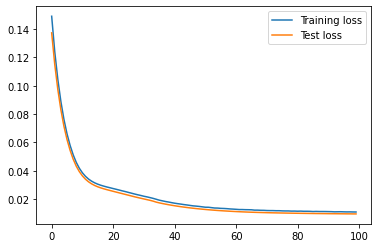

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_55 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.004172823473969142, 0.005423902422470357, 0.00869771237817726, 0.006205969885351286, 0.0052351798622112256, 0.007946358439117571, 0.006925705681559131, 0.009403442006129938, 0.008419183956513214, 0.007491788070702958, 0.0050112683992275765, 0.028113009394603847, 0.004101838405144268, 0.04365271828074973, 0.0430476925664282, 0.010638151891596084, 0.008

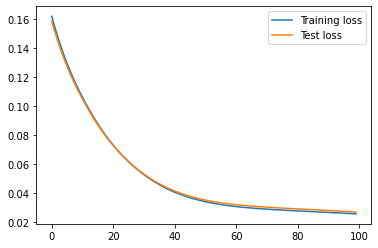

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_56 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.041212378974056, 0.05852785994232233, 0.0712180563007548, 0.02476781390058542, 0.01551128615808141, 0.027746525757330737, 0.007638259771608448, 0.012495720503336218, 0.060467637464171275, 0.010273654373349927, 0.05598421063872853, 0.0708564332869303, 0.042369168933614025, 0.020523893119129104, 0.01790829381619728, 0.029457672432597195, 0.02262627514262

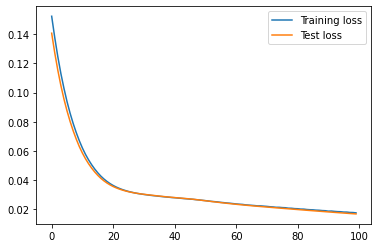

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_57 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.007310151068070679, 0.02704787389270028, 0.035054669233561854, 0.051321543674475834, 0.025089498212050136, 0.022632398990936053, 0.0187341790675321, 0.012434901950224944, 0.017260416503745546, 0.02033079712064786, 0.010152362123026901, 0.012325712508462467, 0.017883592695722785, 0.026659037650745177, 0.019723119497712105, 0.016713632213070793, 0.030973

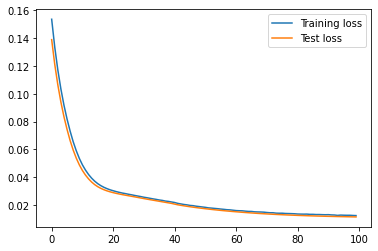

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_58 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.023812408292152604, 0.012863954998725344, 0.09707131315891664, 0.020873291948841403, 0.023181797220461573, 0.010203264920814295, 0.013222536099939524, 0.009311010842533765, 0.020549012626621073, 0.011083947074959204, 0.014922656806447776, 0.030281160198293428, 0.020706802580077368, 0.03227346903752602, 0.027725513173209038, 0.017680433655706502, 0.017

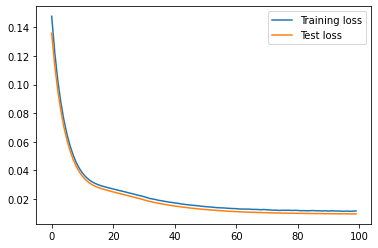

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 64)                50688     
_________________________________________________________________
dense_59 (Dense)             (None, 7)                 455       
Total params: 51,143
Trainable params: 51,143
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.00454519511939517, 0.005834810328451567, 0.008990824606631318, 0.0063295258525093755, 0.005404600787349929, 0.008503029054866471, 0.007497140503671419, 0.009878675571339304, 0.008755301752119391, 0.007723797748310192, 0.005217894517824918, 0.028049127050118323, 0.0041071028457996105, 0.04452517287531269, 0.04368942728303539, 0.011020668090038401, 0.00

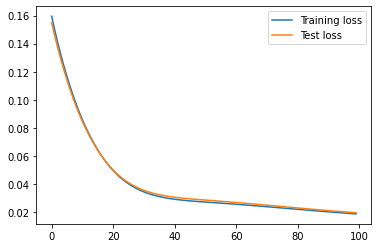

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_36 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_60 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.02660168595840722, 0.041318642636334904, 0.0532573532587516, 0.013432614411223247, 0.007206369264427589, 0.020513653840745456, 0.002870172773214108, 0.006792443520709465, 0.05696679929000733, 0.003159543712984357, 0.03754055292172, 0.04978724805298335, 0.025130943102003096, 0.00893829025332187, 0.007939220113842436, 0.015670571976962883, 0.009847422443

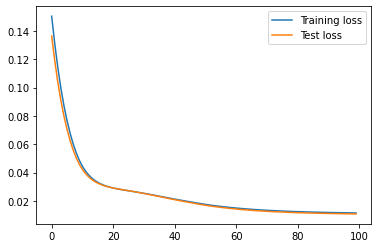

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_37 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_61 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.0069598829299403675, 0.012655397418581873, 0.01585035498815809, 0.02868235400832678, 0.008265722129440942, 0.007592365343693278, 0.005603881249044207, 0.0021246917342198557, 0.0054054639048704955, 0.0067741488652635394, 0.0019741001297656374, 0.0032934241830844257, 0.004724711642925935, 0.010114728938593285, 0.00840927752700996, 0.006090844303019237, 0

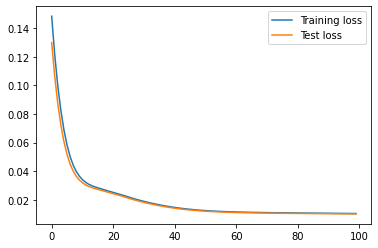

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_38 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_62 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.022578734015659, 0.012926639161118405, 0.09908824103545807, 0.02567532553410956, 0.025441941709557016, 0.006231277780334007, 0.007031922001553019, 0.006967001963033681, 0.018715930637814182, 0.009853983476684139, 0.007957919512170366, 0.021062029268575446, 0.015576986217378621, 0.023482847558625508, 0.020492720189525113, 0.013889509967806848, 0.016191

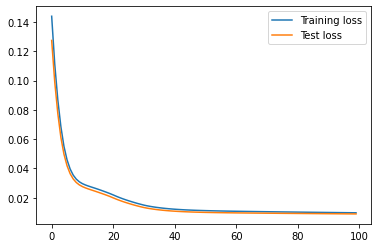

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_39 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_63 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MSE (interval):  [0.0027707165660615374, 0.003561911683423854, 0.0068257146239147914, 0.00534404919511644, 0.003976405486290397, 0.005197222366794969, 0.0044189243102924335, 0.006841565868074083, 0.006153818507300457, 0.005773334658962475, 0.003666644734039437, 0.027770492240961175, 0.004424886162301586, 0.040213847432044404, 0.04208791301269749, 0.01083523454976135, 0.0

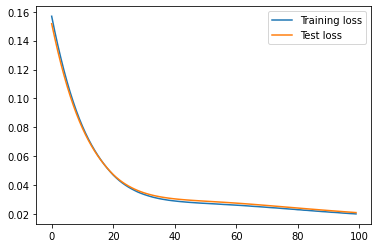

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_40 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_64 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.031055909043061547, 0.04681767585861962, 0.05913680496450979, 0.0156545579583118, 0.008544464541565893, 0.02201308582672417, 0.003614531824756081, 0.008126883913064376, 0.058312836295434475, 0.004760072051015284, 0.04340075011818304, 0.056516876099132266, 0.02976470842778716, 0.011129080447582445, 0.009181917083749016, 0.018734297247387337, 0.0128213

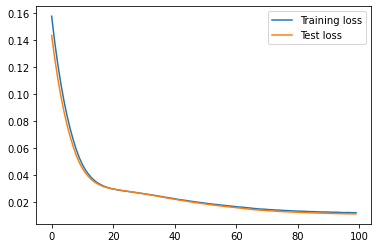

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_41 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_65 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.006465489302562284, 0.013210271366655693, 0.016583869167983982, 0.02951602819809653, 0.008703182279012773, 0.00805336631726407, 0.00603431759022247, 0.002341627975770929, 0.0059107227009137986, 0.007291377783336169, 0.0021812184247340027, 0.0035793648469280015, 0.005014195438564327, 0.010346651398452065, 0.008397051867632399, 0.0061017034135407554, 0

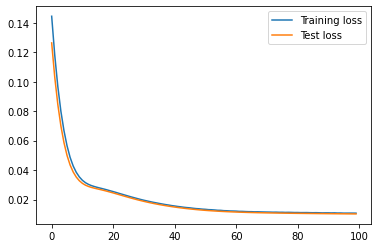

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_42 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_66 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.02255333936461414, 0.012624774079020946, 0.09817285033802493, 0.023685958931569724, 0.024175335420295596, 0.007220151968843831, 0.008297939134048906, 0.006906415669358726, 0.018460203237054884, 0.009736129947181585, 0.009629219158081728, 0.023198539050229425, 0.016053329553739917, 0.02474030001290625, 0.021241005111733102, 0.014036659902558313, 0.01

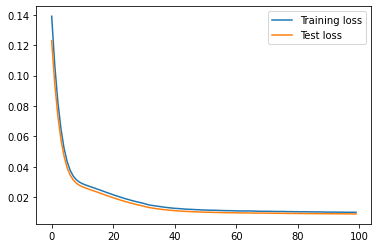

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_43 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_67 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.2
MSE (interval):  [0.0029519080840358924, 0.003816271667395605, 0.007009857050527606, 0.005400967124470769, 0.004026792610082859, 0.0055793222448171165, 0.004732658972768279, 0.007067419763318737, 0.006374555258974267, 0.005836648560944013, 0.0037289781976141967, 0.02774659611324231, 0.004352770111308603, 0.040607034579027514, 0.04199795056047151, 0.010469951267753328, 

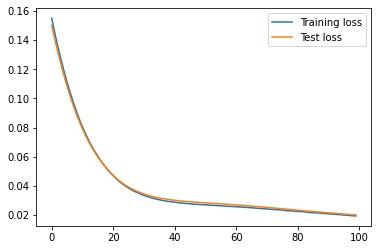

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_44 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_68 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.028835847861565917, 0.04431962757371366, 0.056182357154154615, 0.014737856884104466, 0.007921606530934306, 0.021490043850332898, 0.0034432643234530197, 0.007715273562228374, 0.058074784677436195, 0.003949596756553676, 0.04047100280149607, 0.053148911924966215, 0.027283406545133664, 0.009677655260540112, 0.008072947567208237, 0.016508970161729457, 0.0

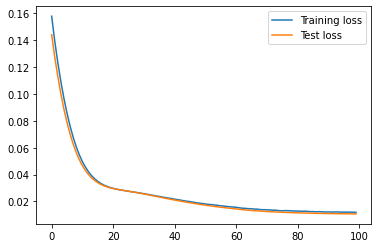

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_45 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_69 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.00723179415919211, 0.01207734675166908, 0.01495580968133124, 0.027474841600191473, 0.007468923038816554, 0.006957543155294843, 0.005089272653354523, 0.0018070625181800487, 0.00506353337238709, 0.006301199236856648, 0.0018509937259035983, 0.00312335585067558, 0.004236795010391299, 0.00926468035088744, 0.007895791028204258, 0.005660288633017834, 0.0129

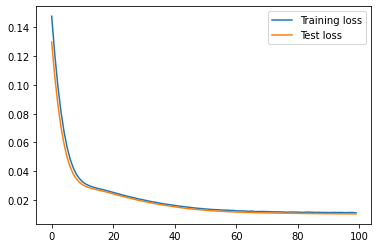

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_46 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_70 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.022190671011588035, 0.012501173044045442, 0.09792429917680627, 0.023882131125284495, 0.024126458929718604, 0.006959668382429689, 0.008089057524452008, 0.00701203040429326, 0.01849626597605233, 0.009694833554281754, 0.00937325405282406, 0.022898832179764992, 0.0161667163079723, 0.024548380408045238, 0.0212709896882838, 0.014172270125137791, 0.0160692

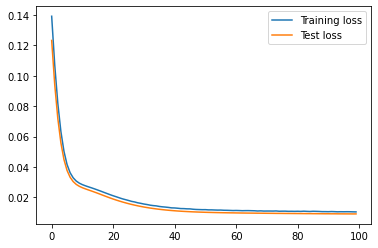

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_47 (Bidirectio (None, 128)               101376    
_________________________________________________________________
dense_71 (Dense)             (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0.4
MSE (interval):  [0.0031429115884502273, 0.004088135630602048, 0.007274989203741811, 0.005381265868046674, 0.004200111193962844, 0.005969019589299153, 0.005084463482229954, 0.007378741313784433, 0.00652700581408031, 0.005890695333749006, 0.0037602715877125903, 0.027578587780486226, 0.004312406982251105, 0.04111122473841533, 0.04242394668524087, 0.01059050747945938, 0.0

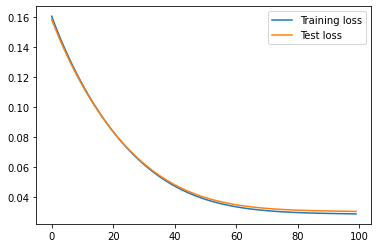

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 1, 64)             50688     
_________________________________________________________________
lstm_97 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_72 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.05113746695548928, 0.0694582099926525, 0.08289582819686205, 0.032809849145581084, 0.021989947115798714, 0.03388269304975568, 0.012046203704293086, 0.0176957396096051, 0.06489977930115336, 0.0165380192754258, 0.06761988873352

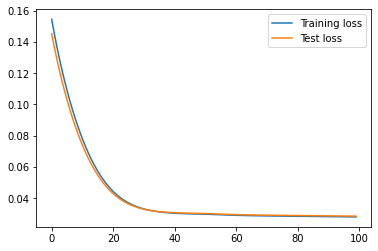

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 1, 64)             50688     
_________________________________________________________________
lstm_99 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_73 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.014009176376150987, 0.049053495367323716, 0.06085593834203402, 0.08179370608351226, 0.04896806365806177, 0.04429469875218014, 0.04021563839445922, 0.031691765456344, 0.03837922013294052, 0.04171464226549558, 0.02877885892251

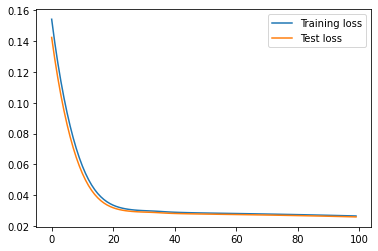

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_101 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_74 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.04480731213282395, 0.02851822081928341, 0.10674373426549469, 0.023844980506398526, 0.03586388512381485, 0.04304717812919989, 0.05516919787727862, 0.03910557501720697, 0.047805696459753175, 0.03753208452274391, 0.05939383494

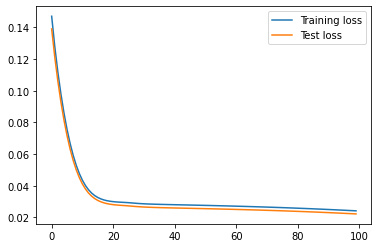

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_102 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_103 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_75 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.03578994472211759, 0.03991160192526877, 0.04350429888498703, 0.03686471774043249, 0.03659688820646677, 0.04710085567369658, 0.04389010126137042, 0.047337552008684725, 0.04546662703173102, 0.04174666221037374, 0.036321166994

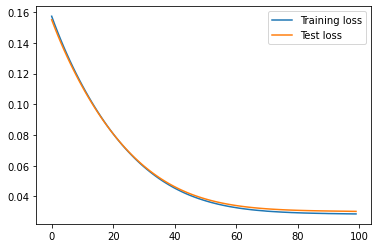

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_105 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_76 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.05171267051939919, 0.07005378490014534, 0.08354154532779441, 0.03345605223044653, 0.022553913358154074, 0.03442762860608387, 0.012428600732878945, 0.01809862527547271, 0.06527564859633068, 0.01699400801070234, 0.0682678895

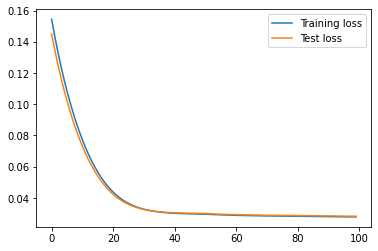

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_106 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_107 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_77 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.01390710749027286, 0.04893722811747076, 0.06072156471366595, 0.08159982877675377, 0.048820019753683094, 0.04419218042416365, 0.04012763008151004, 0.031592662606271915, 0.03830881853043268, 0.041634784656967634, 0.028715051

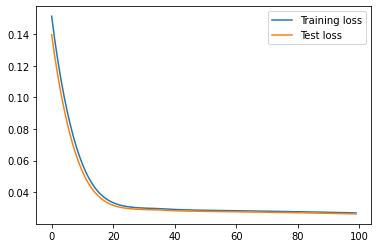

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_108 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_109 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_78 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.04548210254870355, 0.029070717742018002, 0.1074015960122259, 0.024230866715437775, 0.03630791137194527, 0.04374960681993149, 0.055972685199646675, 0.03974135028485242, 0.048540232270689945, 0.03821942809320587, 0.06022149

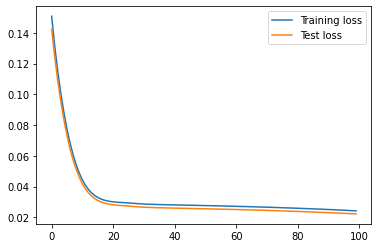

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_110 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_111 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_79 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.03592241556699654, 0.040006988415760655, 0.04351682504888491, 0.036663351235412325, 0.03649220681940538, 0.04706390918415439, 0.04388140857918188, 0.04726272014002981, 0.0453440784227236, 0.04150257984708462, 0.0361370772

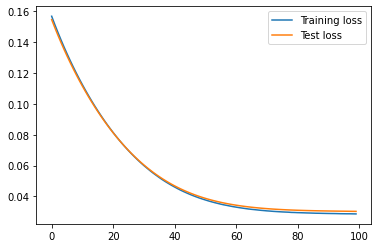

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_112 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_113 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_80 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.051382522458360266, 0.06967998077847629, 0.08314417296268013, 0.03325242359798202, 0.022452532048711355, 0.034432366142157535, 0.012238173041623668, 0.018003961402947816, 0.06534896177722008, 0.01685551511452234, 0.0678716

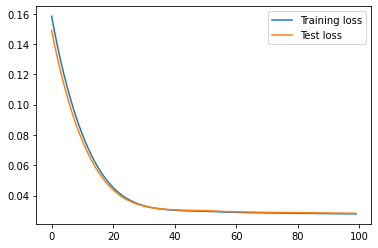

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_114 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_115 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_81 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.013861843052187137, 0.048771884427489046, 0.06052893871258545, 0.08139908073020966, 0.048706631417319714, 0.04405234916235453, 0.04002056424880201, 0.03152109679649584, 0.03820724629414534, 0.04150004451574724, 0.028669278

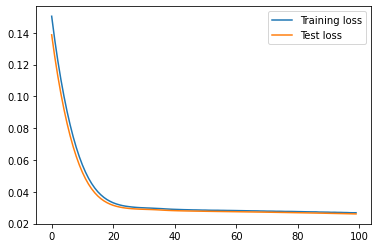

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_116 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_117 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_82 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.04495724349024905, 0.02869929549342487, 0.10677420567870806, 0.024022341872556092, 0.035944434573009075, 0.04321544981628124, 0.0553866463014856, 0.039343652587766495, 0.048041522735729814, 0.03769335716684249, 0.05962246

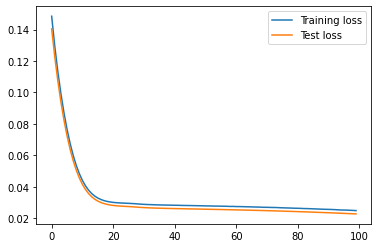

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_118 (LSTM)              (None, 1, 64)             50688     
_________________________________________________________________
lstm_119 (LSTM)              (None, 64)                33024     
_________________________________________________________________
dense_83 (Dense)             (None, 7)                 455       
Total params: 84,167
Trainable params: 84,167
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.0367573242484858, 0.04090631373193381, 0.044428757063412504, 0.037576914590317756, 0.03739051880880392, 0.04806969473637374, 0.04482531434872986, 0.048226121962735694, 0.04632412886296931, 0.042479239761762856, 0.03706111

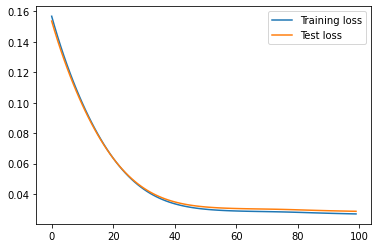

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_48 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_84 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.051317585356758046, 0.07006649503143438, 0.08354723664316614, 0.031876363930807984, 0.020732612630776463, 0.03298941238608677, 0.011402408095299117, 0.01716547398869547, 0.06473703024364243, 0.015847581695457587, 0.0678244

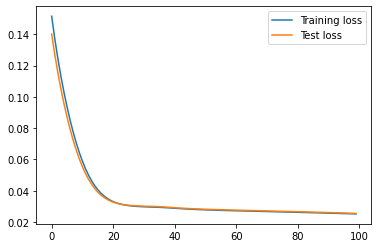

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_50 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_85 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.01312078077795117, 0.04586764151879054, 0.05737868011679633, 0.07770587583321945, 0.0456342649288542, 0.041172394720238766, 0.03686915713063042, 0.028588086524645666, 0.03485678672690743, 0.038452734040869734, 0.0253530230

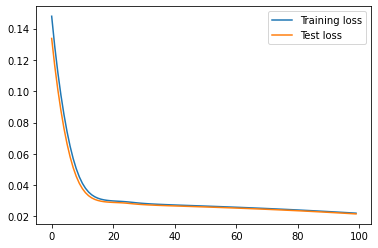

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_52 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_86 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.04032608988927677, 0.024974925036076456, 0.10274295027401033, 0.02249745197228289, 0.032876492672325446, 0.037104448224584176, 0.04764432134707671, 0.03289201997020947, 0.04224736022297293, 0.03159436455462128, 0.05121124

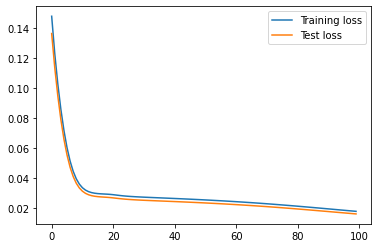

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_54 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_87 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0
MSE (interval):  [0.022644491320534144, 0.02662488844154203, 0.03138474894408968, 0.02527240763759307, 0.025510554988743803, 0.033267603327528504, 0.03037536699931869, 0.03451915166598545, 0.03301251391011257, 0.02927106759826919, 0.02481933

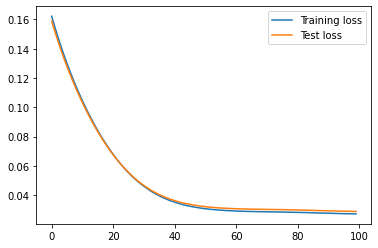

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_56 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_88 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.051286175272252876, 0.07003847439565496, 0.08351466041910628, 0.03197192726033141, 0.020892697076695704, 0.033174398326082155, 0.011503527745714694, 0.01727330113187366, 0.06493872281550596, 0.015922637351780265, 0.06775

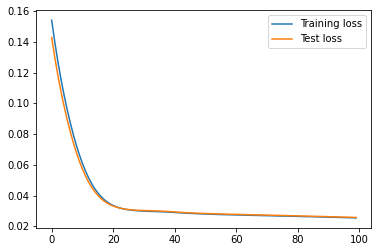

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_58 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_89 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.013285352919150941, 0.04602790213955034, 0.057580738415708765, 0.07795858935112067, 0.045938832612591796, 0.04139270686469639, 0.03709502089311302, 0.028826269231753292, 0.03504549242123695, 0.03863594906995006, 0.025572

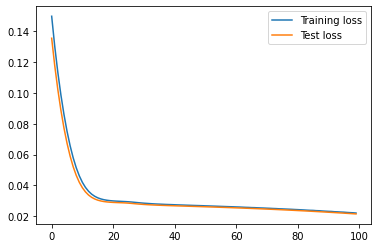

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_60 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_90 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.03988126671174541, 0.024626419654980834, 0.10211000343718167, 0.022227051904857426, 0.03261220729161453, 0.03676122899300286, 0.047353986952430205, 0.03266185280517675, 0.04184056555303479, 0.03125001170805523, 0.050938

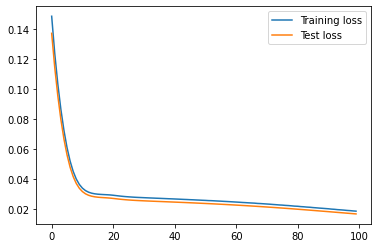

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_62 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_91 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.2
MSE (interval):  [0.023494532882718237, 0.027536671128473245, 0.03231466356062031, 0.026074840348363586, 0.026366034417670953, 0.034312447152582796, 0.031376888138765935, 0.03553870716028281, 0.033987654447888156, 0.03014970168234348, 0.02

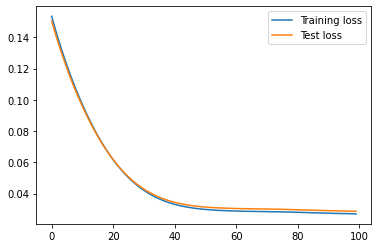

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_64 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_65 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_92 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.051469716251761256, 0.07028129059576063, 0.08375990517795019, 0.03214788771375814, 0.02099022456241073, 0.03320118000556249, 0.011536585264236367, 0.01736676616876918, 0.06495666326476826, 0.015987203640439214, 0.0679884

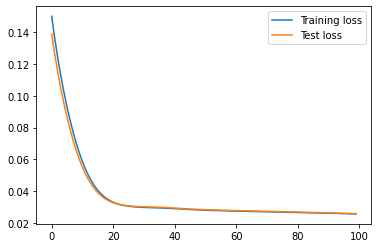

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_66 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_67 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_93 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.013369385246603218, 0.04638494325419223, 0.05795782824861817, 0.078402252946814, 0.046172702693313895, 0.04165067174679799, 0.03732767439214513, 0.02902776553154191, 0.035320039256475866, 0.03892094708239061, 0.025773448

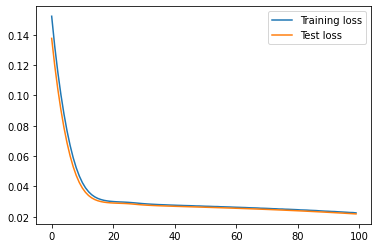

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_68 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_69 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_94 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.0402874748355576, 0.02494892490046498, 0.10249426827067509, 0.022360811550502797, 0.03269979614248898, 0.0373301500803791, 0.04801637476100508, 0.03315961348458326, 0.042324721172917634, 0.03175742319685274, 0.051648334

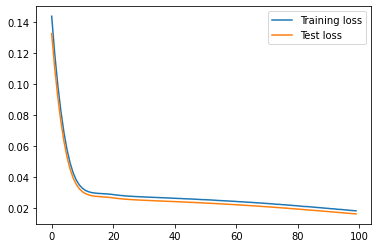

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_70 (Bidirectio (None, 1, 128)            101376    
_________________________________________________________________
bidirectional_71 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_95 (Dense)             (None, 7)                 903       
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 2
Dropout percent: 0.4
MSE (interval):  [0.02308245904402741, 0.027042444493937574, 0.03172196961220054, 0.025552015557228254, 0.025799437155780782, 0.03372185398724729, 0.030840935037953647, 0.03491840033737909, 0.03334717354612492, 0.029582378780885068, 0.0250

In [29]:
#iterate through everything
#this takes a long time to run
model_results_list = []
for t in timelags:
  for n in num_layers:
    for dirs in directions:
      for d in dropouts:
        for c in cross_validation_intervals:
          model_results_list.append(LSTM_function_mse_list(df_normal, t, c, dirs, n, d, 100))

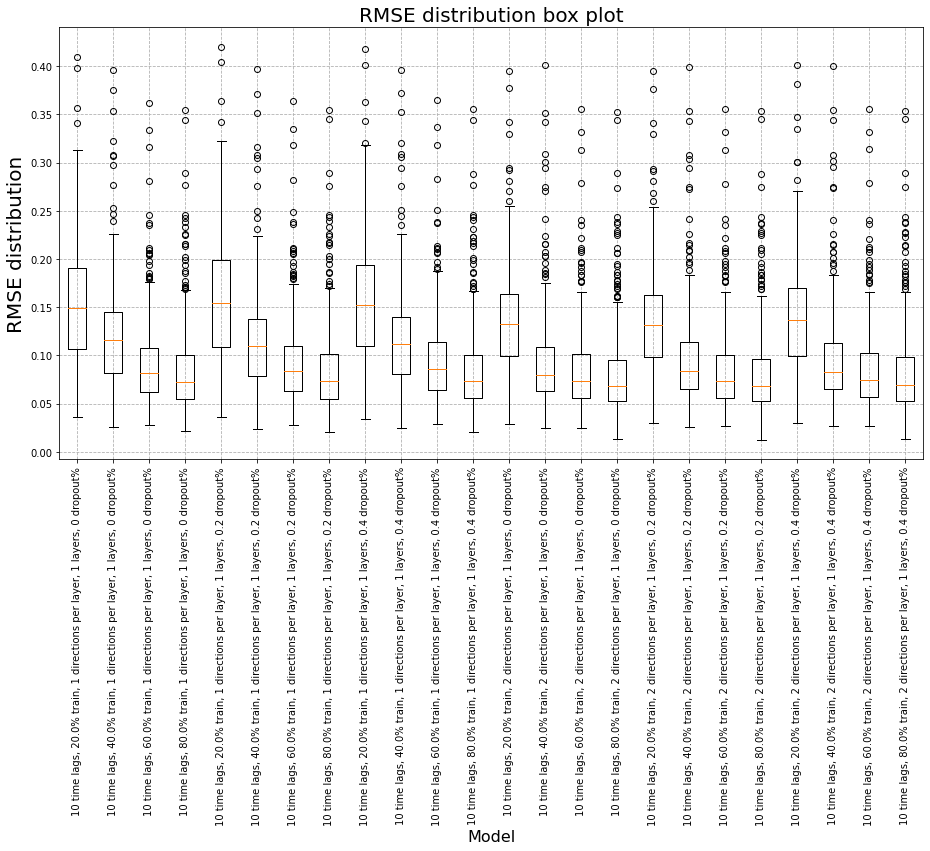

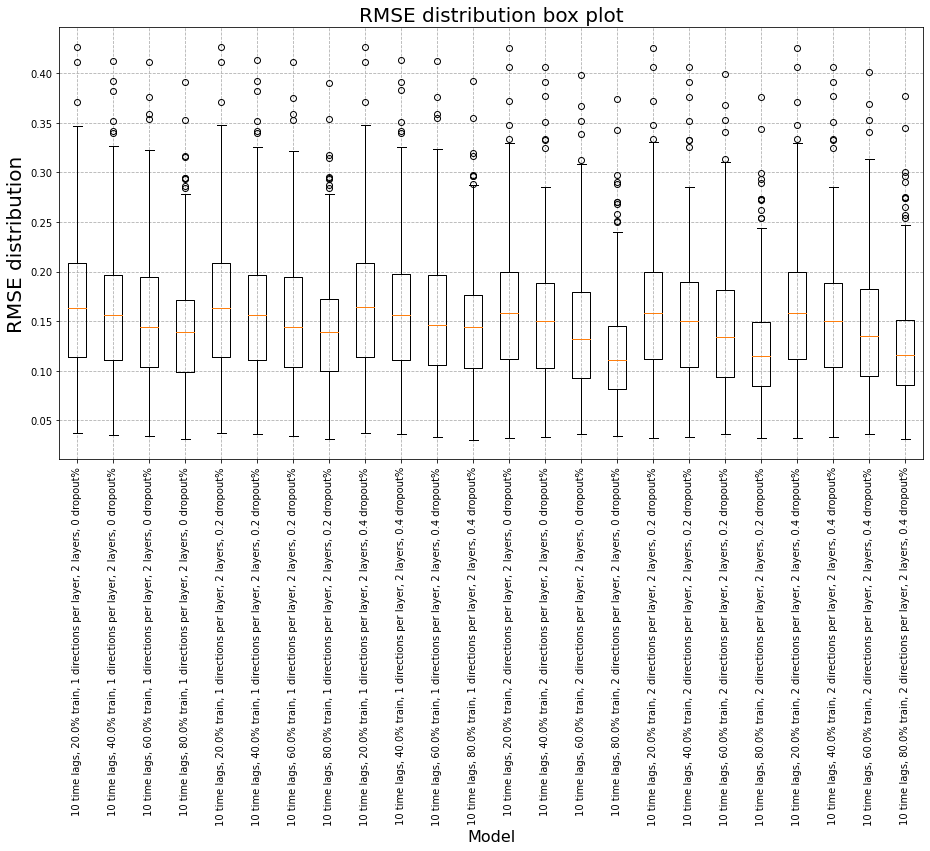

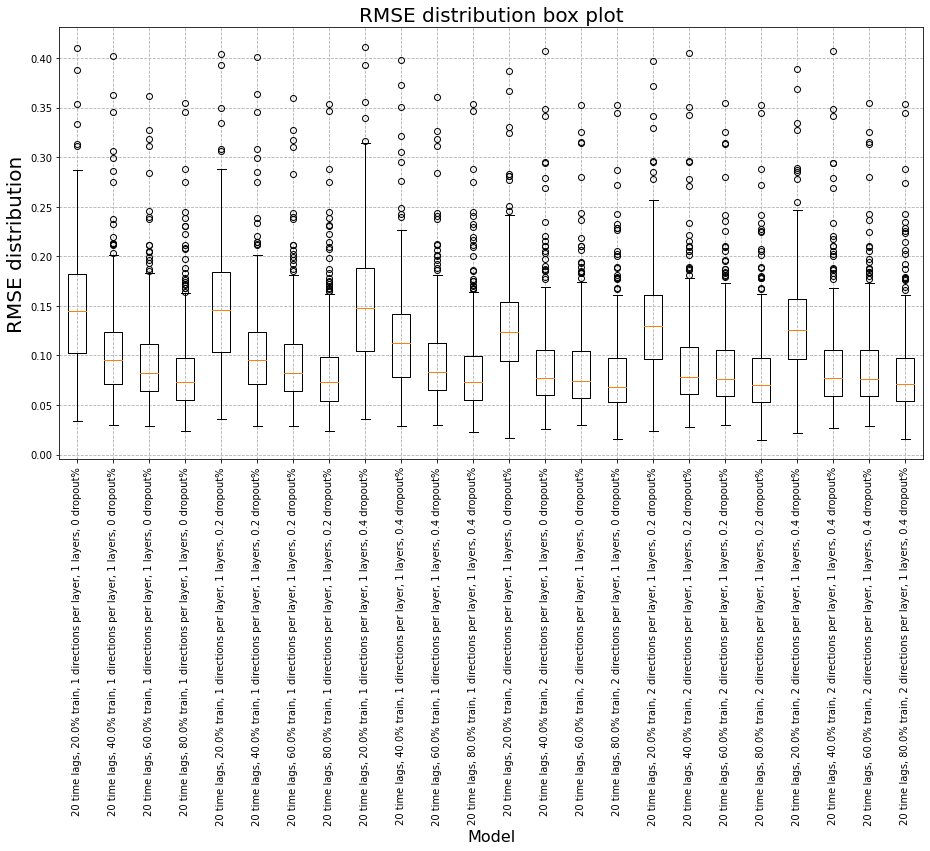

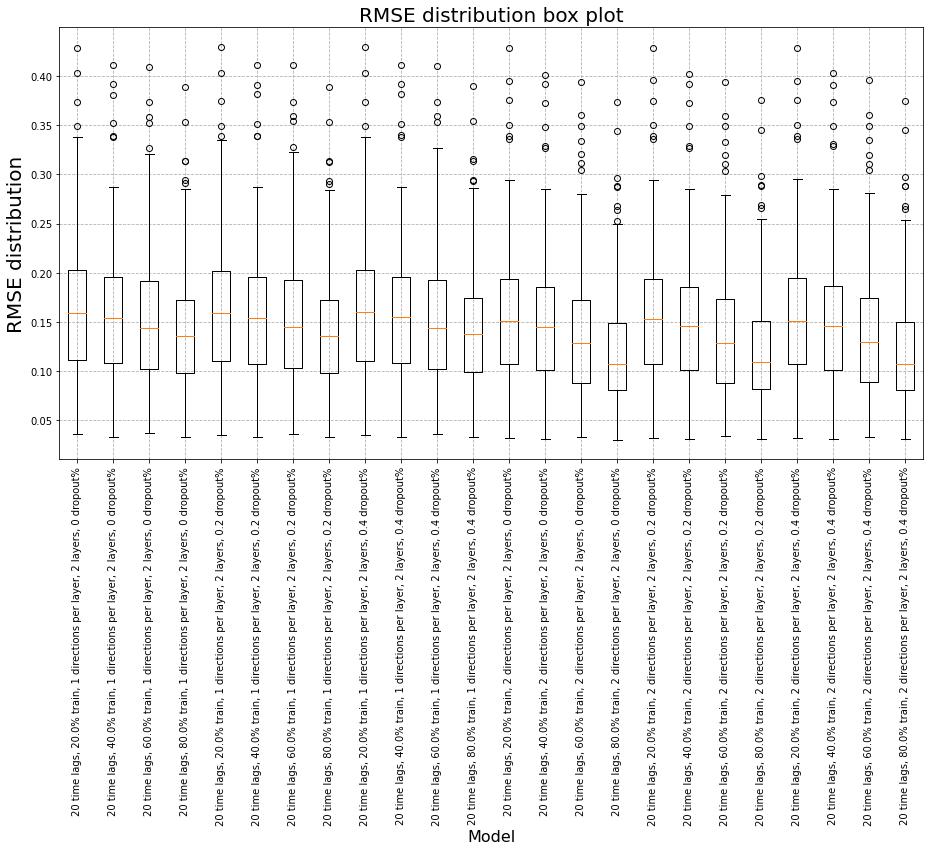

In [36]:
for x in range(0,4):

  fig = plt.figure(figsize =(12, 6)) 
  ax = fig.add_axes([0, 0, 1, 1]) 
  model_names = []
  model_rmses = []
  for i in model_results_list[x*24:(x+1)*24]:
    model_name = (str(i[0]) + " time lags, " + str(i[1]*100) + "% train, " + str(i[2]) + " directions per layer, " + str(i[3]) + " layers, " + str(i[4]) + " dropout%")
    model_names.append(model_name)
    model_rmses.append(i[6])
  ax.set_xticklabels(model_names, rotation='vertical')
  bp = ax.boxplot(model_rmses) 
  plt.title("RMSE distribution box plot", size=20)
  plt.xlabel('Model', size=16)
  plt.ylabel('RMSE distribution', size=20)
  plt.grid(ls='--')
  plt.show()

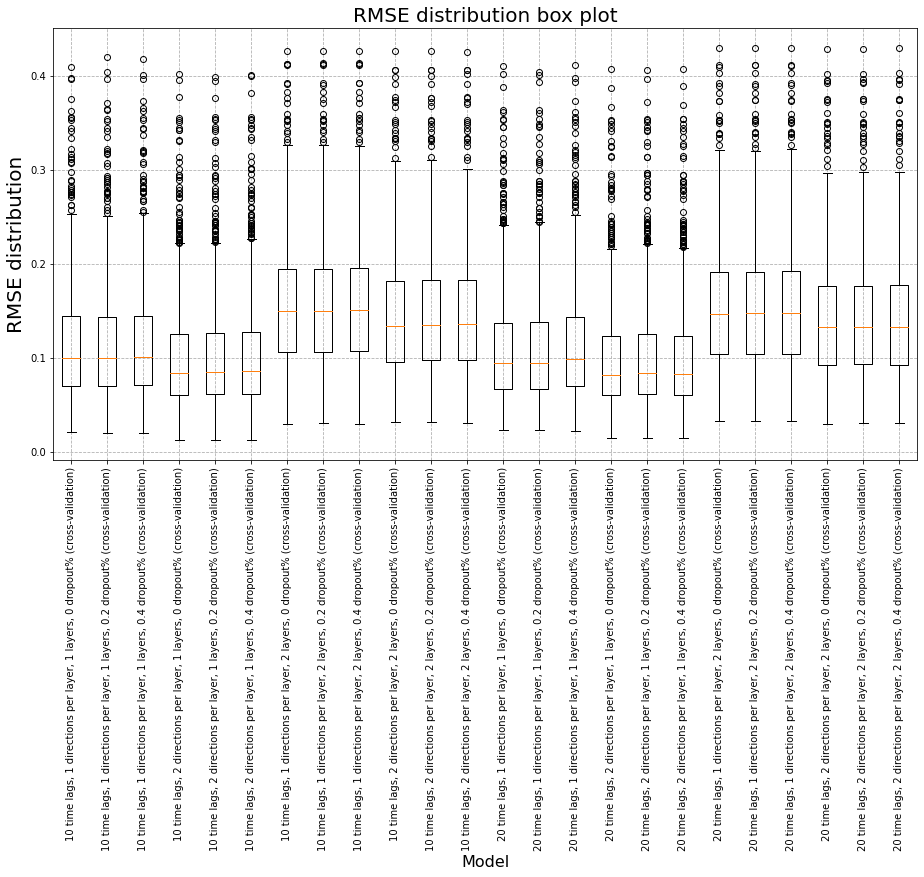

In [35]:
#this needs to be fixed

fig = plt.figure(figsize =(12, 6)) 
ax = fig.add_axes([0, 0, 1, 1]) 
model_names = []
model_rmses = []
for i in model_results_list:
  model_name = (str(i[0]) + " time lags, " + str(i[2]) + " directions per layer, " + str(i[3]) + " layers, " + str(i[4]) + " dropout% (cross-validation)")
  model_names.append(model_name)
  model_rmses.append(i[6])

index_value = 1
model_agg_rmses_temp = []
model_agg_rmses = []
for i in model_rmses:
  for x in i:
    model_agg_rmses_temp.append(x)
  if((index_value%4)==0):
    model_agg_rmses.append(model_agg_rmses_temp)
    model_agg_rmses_temp = []
  index_value +=1


model_names_big = []
index_value = 1
for i in model_names:
  if((index_value%4)==0):
    model_names_big.append(i)
  index_value+=1
ax.set_xticklabels(model_names_big, rotation='vertical')
bp = ax.boxplot(model_agg_rmses) 
plt.title("RMSE distribution box plot", size=20)
plt.xlabel('Model', size=16)
plt.ylabel('RMSE distribution', size=20)
plt.grid(ls='--')
plt.show()